Объявления библиотек 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import librosa
import numpy as np
import IPython.display as ipd
import noisereduce as nr
import matplotlib.pyplot as plt
import librosa.display
import python_speech_features
from python_speech_features import mfcc
import sklearn
import os
#для нейронных сетей
import keras
import tensorflow as tf
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,LSTM,TimeDistributed
from keras.layers import Convolution2D, MaxPooling2D,MaxPooling1D,Conv2D, AveragePooling2D
from keras.optimizers import Adam,SGD
from keras.utils import np_utils
from sklearn import metrics
import random
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
import datetime
import sklearn
from sklearn.model_selection import train_test_split  
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc

Класс для работы с данными 

In [2]:
class Bront:
    def __init__(self ,ww,hop, ww_mfc=2048, hop_mfc=512,sr= 22050, n_input=20, n_output=0):
        self.window_wide = ww
        self.window_wide_mfc = ww_mfc
        self.hop = hop
        self.hop_mfc = hop_mfc
        self.n_input = n_input
        self.n_output = n_output
        self.hb_mean = None
        self.sr = sr
        
    def _spectrum(self, data):
        pass
    
    def data_maker(self, path, path_save):
        files = np.array(os.listdir(path))
        for file in files:
            features = np.load(path+file)
            np.save(path_save+file.split('.')[0]+"__data.npy", self._data_ex(features))
            print(path_save+file.split('.')[0]+"__data.npy")    
            
    def _data_ex(self, features):
        rng = range(0, features.shape[1], self.hop)
        dat= np.zeros([len(rng), self.n_input, self.window_wide])
        for i,step in enumerate(rng):
            try:
                dat[i] = features[:,step:step+self.window_wide]
            except:
                pass
        return dat
    
    def _mfcc(self, data):
        m_htk = librosa.feature.mfcc(y=data, sr=self.sr, hop_length=self.hop_mfc,win_length=self.window_wide_mfc, n_mfcc=self.n_input)
        m_htk = sklearn.preprocessing.scale(m_htk, axis=1)
       #mfcc(data,sr,1/sr*(2*self.hop),1/sr*(2*self.hop), numcep = n, nfft = int(sr*self.window_wide) )
        return m_htk
    
    def feature_ex_and_safe(self, path, path_save):
        files = np.array(os.listdir(path))
        for file in files:
            x , sr = librosa.load(path+file)
            np.save(path_save+file.split('.')[0]+"__mfcc.npy",self._mfcc(x[:]))
            print(path_save+file.split('.')[0]+"__mfcc.npy")    
            
    def mark_ex_and_save(self, path, path_save):
        files = np.array(os.listdir(path))
        for file in files:
            start, end = self._get_mark(path+file)
            steps = range(0,end[-1], self.hop*self.hop_mfc)
            target = np.zeros(len(steps))
            k=0
            for i,step in enumerate(steps): 
                if step>end[k]:
                    k+=1
                    if k>=end.shape[0]:
                        break
                if (step<start[k]) and (end[k]<step+self.window_wide*self.hop_mfc): 
                    target[i]=1
            np.save(path_save+file.split('.')[0]+"__target.npy",target)
            print(path_save+file.split('.')[0]+"__target.npy")
            
    def _get_mark(self, path):
        file = open(path)
        raw_mark = file.read(-1)    
        
        start = np.zeros(len(raw_mark.split('\t\n'))-1)
        end = np.zeros(len(raw_mark.split('\t\n'))-1)
        
        for i,mark in enumerate(raw_mark.split('\t\n')):
            if len(mark)==0:
                continue
            try :
                start[i], end[i] = mark.split('\t')
            except:
                try:
                    start[i], end[i] = mark.split('\t')[1].split("\n")[1],mark.split('\t')[2]
                except:
                    pass
        start = np.array(start*self.sr, dtype="int")
        end = np.array(end*self.sr, dtype="int")
        return start, end
            
            
    def _wavelet(self, data):
        pass

Формирование данных бд

In [5]:
volonter = Bront(20,1)
path_mark = "data/marks/source/"
path_mark_save = "data/marks/"
volonter.mark_ex_and_save(path_mark, path_mark_save)

path_wav = "data/wav/"
path_features_save = "data/features/"
volonter.feature_ex_and_safe(path_wav , path_features_save)


volonter.data_maker("data/features/","data/dt/")

data/marks/chips__mark__target.npy
data/marks/clear__mark__target.npy
data/marks/fast__mark__target.npy
data/marks/music__mark__target.npy
data/features/chips__mfcc.npy
data/features/clear__mfcc.npy
data/features/fast__mfcc.npy
data/features/music__mfcc.npy
data/features/speak__mfcc.npy
data/features/sport__mfcc.npy
data/dt/chips__mfcc__data.npy
data/dt/clear__mfcc__data.npy
data/dt/fast__mfcc__data.npy
data/dt/music__mfcc__data.npy
data/dt/speak__mfcc__data.npy
data/dt/sport__mfcc__data.npy


In [20]:
input_shape = (20, 20, 1)
output_shape = 1

model = Sequential()

model.add(Conv2D(5, kernel_size=(5, 5),
                 activation='relu',
                 input_shape=input_shape))
model.add(AveragePooling2D((2, 2)))

# Второй сверточный блок
model.add(Conv2D(16, kernel_size=(7, 7),
                 activation='relu'))
model.add(AveragePooling2D((2, 2)))

# Разворачиваем изображение в вектор
model.add(Flatten())

# Полносвязные слои
#model.add(layers.SimpleRNN(128, activation = 'relu'))
model.add(Dense(units=120, activation='relu'))
model.add(Dense(units=84, activation='relu'))
model.add(Dense(units=output_shape, activation = 'softmax'))
model.summary()
model.compile(optimizer=tf.keras.optimizers.RMSprop(), 
              loss =tf.keras.losses.BinaryCrossentropy(), 
              metrics=['acc','mse'])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 16, 16, 5)         130       
_________________________________________________________________
average_pooling2d_13 (Averag (None, 8, 8, 5)           0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 2, 2, 16)          3936      
_________________________________________________________________
average_pooling2d_14 (Averag (None, 1, 1, 16)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 120)               2040      
_________________________________________________________________
dense_20 (Dense)             (None, 84)               

In [28]:
test_target = np.load(path_mark_save + "fast__mark__target.npy")
test_data = np.load("data/dt/fast__mfcc__data.npy")[:test_target.shape[0]].reshape([test_target.shape[0],20, 20,1])
test_target.shape, test_data.shape

((2669,), (2669, 20, 20, 1))

In [29]:
model.fit(test_data,test_target, batch_size= 70, epochs= 3)

Epoch 1/3
2669/2669 [==============================] - 0s 112us/step - loss: 14.6266 - acc: 0.0461 - mse: 0.9539
Epoch 2/3
2669/2669 [==============================] - 0s 110us/step - loss: 14.6266 - acc: 0.0461 - mse: 0.9539
Epoch 3/3
2669/2669 [==============================] - 0s 110us/step - loss: 14.6266 - acc: 0.0461 - mse: 0.9539


Временное изображение бд

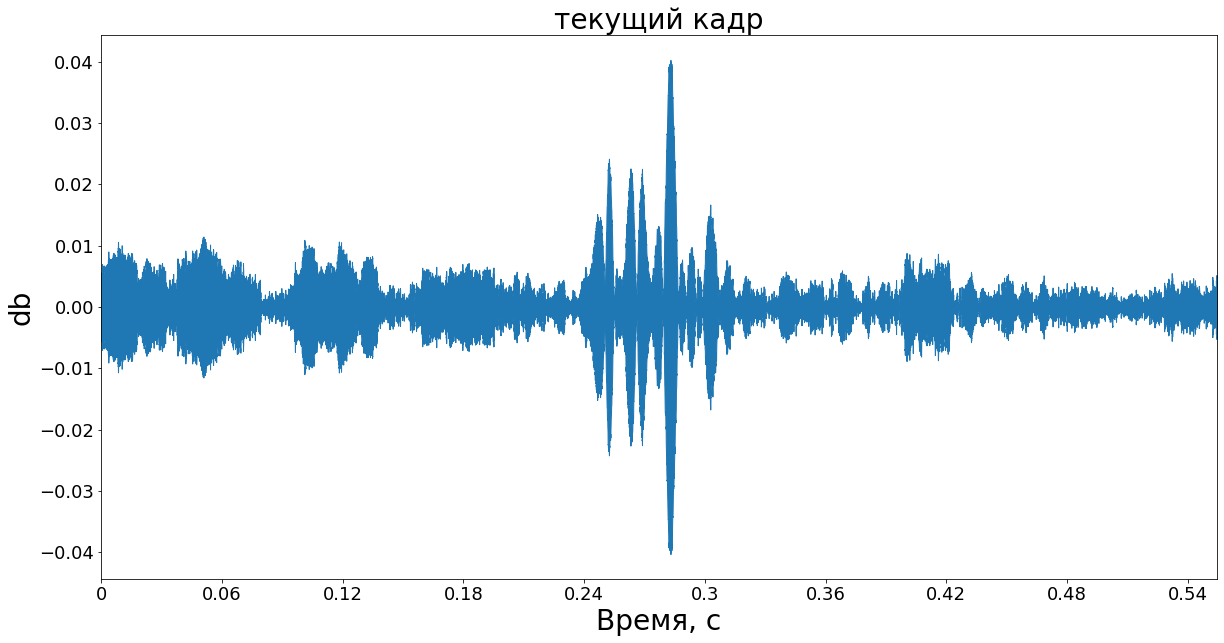

In [114]:
pcm,sr = librosa.load('data/wav/clear.wav')
plt.figure(figsize=[20,10])
librosa.display.waveplot(pcm[:12228], x_axis='time')
plt.xlabel('Время, c',fontsize=28)
plt.ylabel('db',fontsize=28)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Текущий кадр',fontsize=28)
plt.show()

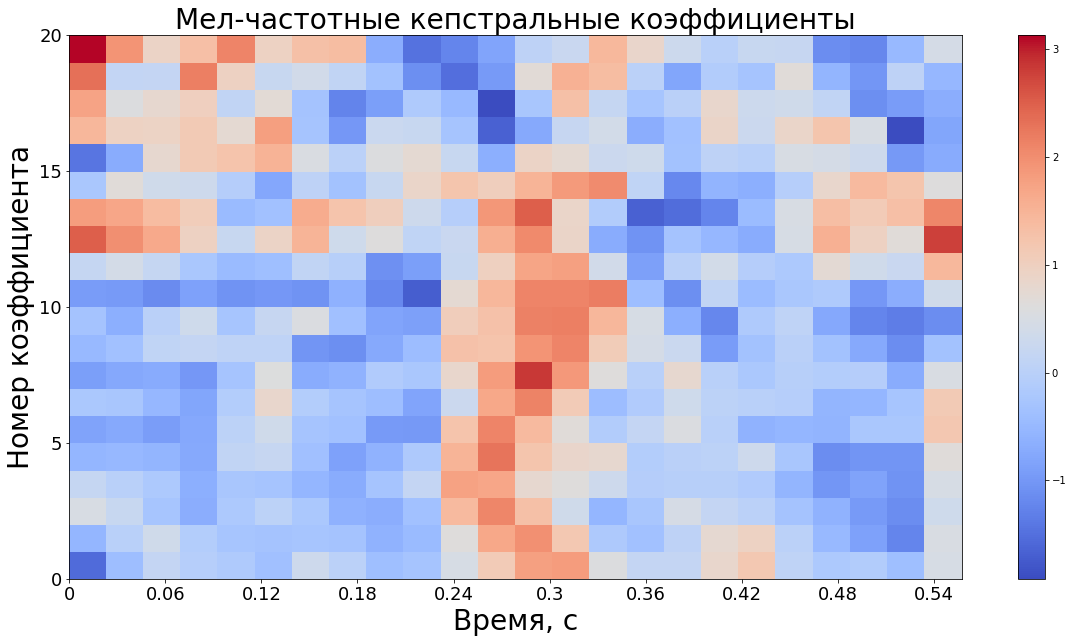

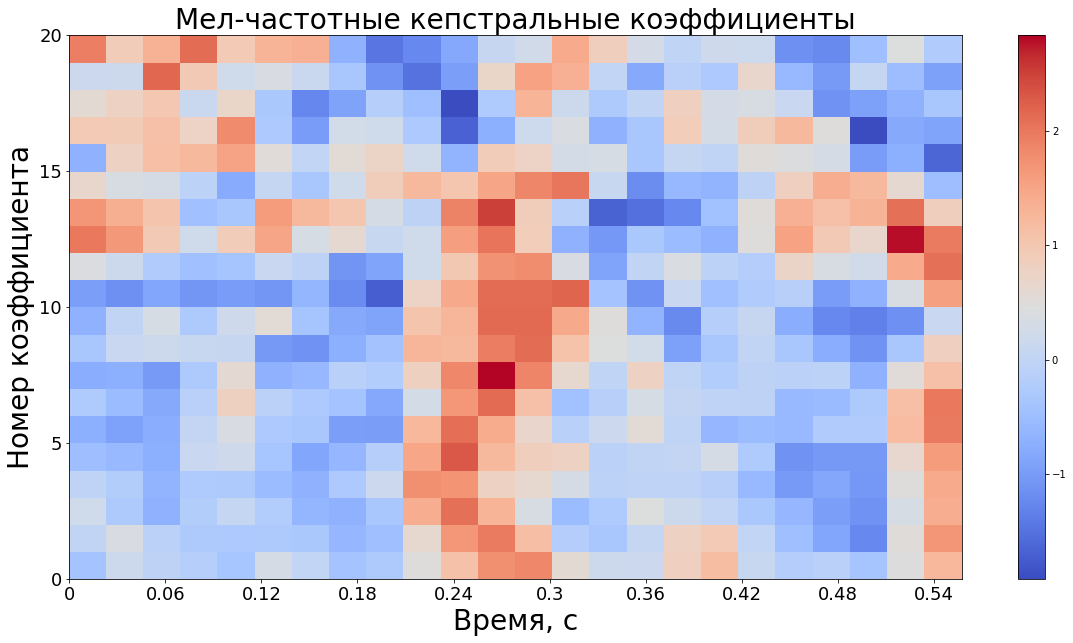

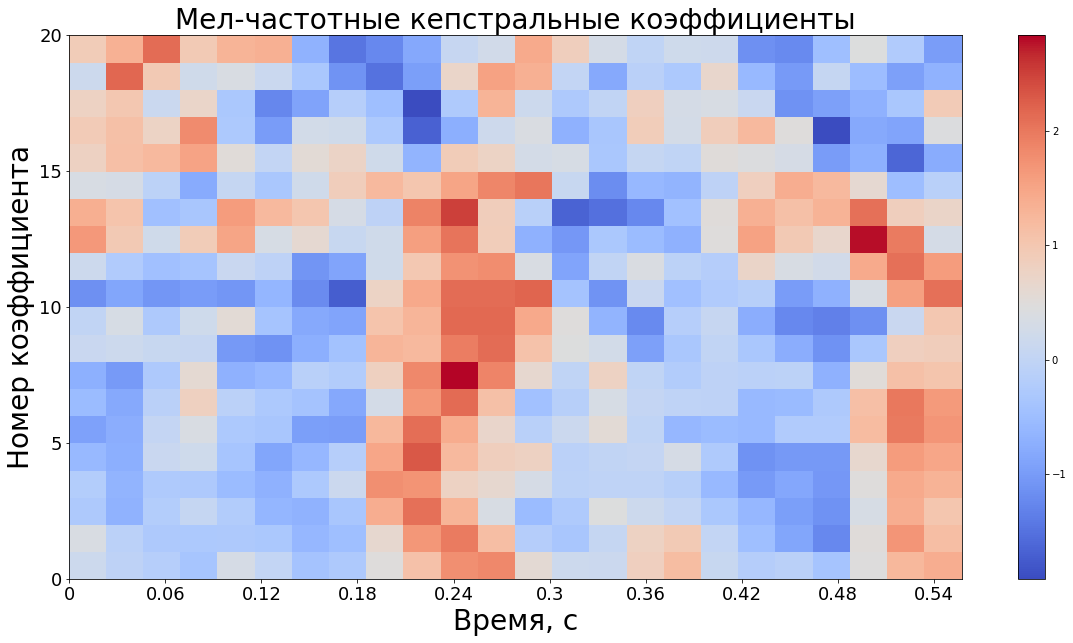

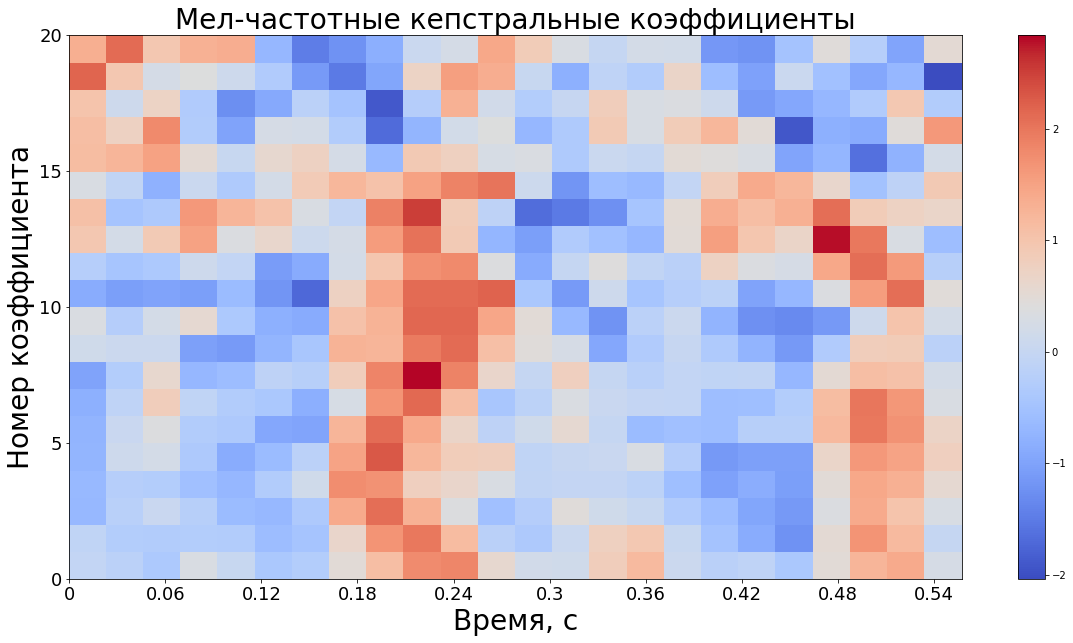

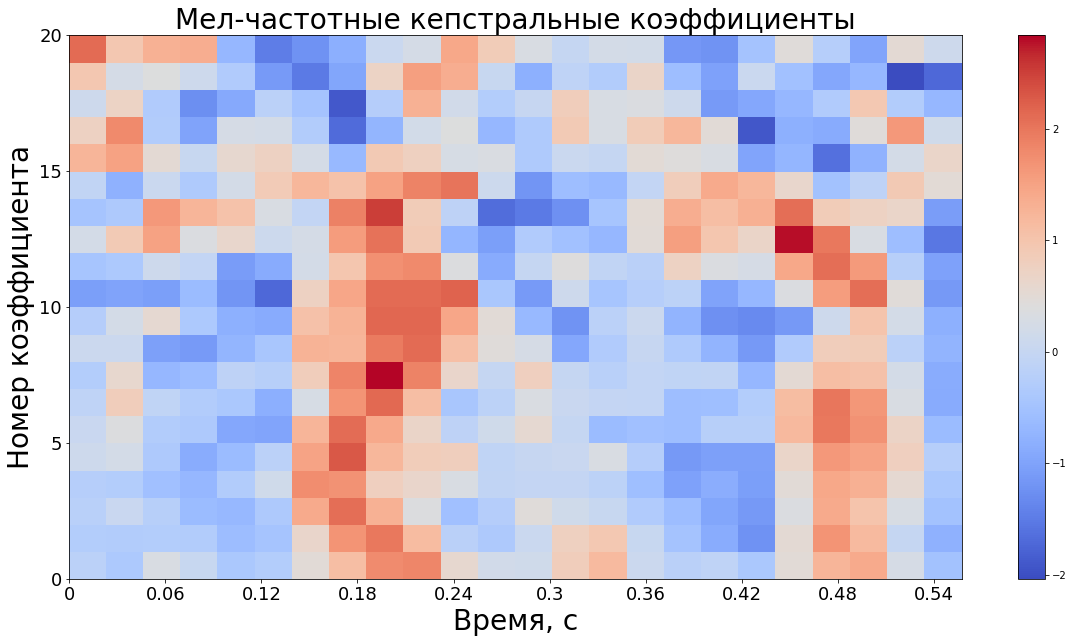

In [116]:
import time
tt32= np.load("data/features/clear__mfcc.npy")
#mt = np.load(path_mark_save + "clear__mark__target.npy")
whiw = 20
hiphop = 1
for i in range(5):
    #if mt[i]==1:
    #    print("NICE!!!")
    
    plt.figure(figsize=[20,10])
    librosa.display.specshow(tt32[:,i:i+24], x_axis='time')
    plt.colorbar()
    plt.xlabel('Время, c',fontsize=28)
    plt.ylabel('Номер коэффициента',fontsize=28)
    plt.xticks(fontsize=18)
    plt.yticks(range(0,21,5), fontsize=18)
    plt.title('Мел-частотные кепстральные коэффициенты',fontsize=28)
    plt.show()
    
    #time.sleep(2)
   # ipd.clear_output()
        

Попытка обучить кбс на всей выборке

In [256]:
t = np.load("data/dt/fast__mfcc__data.npy")
targ = np.load("data/marks/fast__mark__target.npy")
T_data = t.reshape([-1,400])[:targ.shape[0]]

In [257]:
test, train, target_test, target_train = train_test_split(T_data, targ, train_size=0.8,shuffle = True)

In [258]:
%%time
from sklearn.neighbors import KNeighborsClassifier
f1 = np.zeros(len(range(3, 20)))
acc = np.zeros(len(range(3, 20)))
for i,k in enumerate(range(3, 20)):
    model = KNeighborsClassifier(n_neighbors= k).fit(train,target_train)
    predict = model.predict(test)
    f1[i], acc[i] =f1_score(predict,target_test), accuracy_score(predict,target_test)

model = KNeighborsClassifier(n_neighbors= 3+f1.argmax()).fit(train,target_train)
predict = model.predict(test)
3+f1.argmax(),f1.max(), acc.max()

Wall time: 21.6 s


(3, 0.4785276073619632, 0.9601873536299765)

In [71]:
target_test[target_test== True] == predict[target_test== True]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False,  True, False, False, False, False, False, False,  True,
       False, False,  True, False, False, False,  True, False, False,
       False,  True, False, False, False, False, False, False, False,
       False])

In [75]:
predict.sum(), target_test.sum()

(20.0, 46.0)

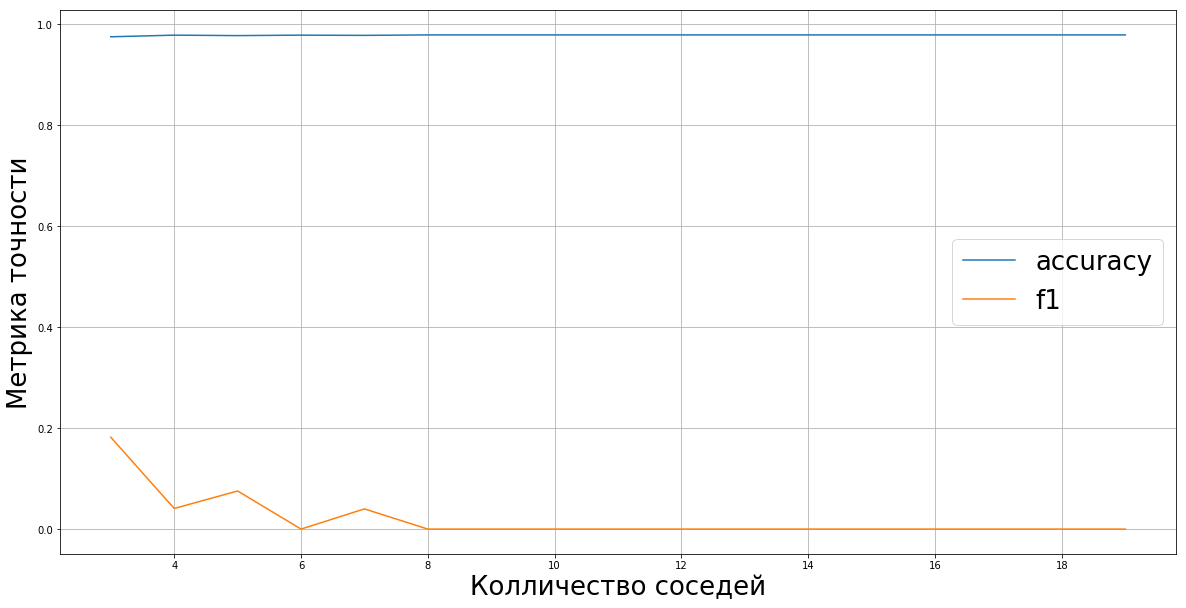

In [73]:
import matplotlib.pyplot as plt
plt.figure(figsize=[20,10])
plt.plot( range(3,20), acc, label="accuracy")
plt.plot(range(3,20), f1,  label="f1")
plt.ylabel('Метрика точности', fontsize=26)
plt.xlabel('Колличество соседей', fontsize=26)
plt.grid()
plt.legend(fontsize=26)
plt.show()

In [53]:
%%time
from sklearn.ensemble import RandomForestClassifier
f1 = np.zeros(len(range(10, 200, 10)))
acc = np.zeros(len(range(10, 200, 10)))
for i,k in enumerate(range(10, 200, 10)):
    model = RandomForestClassifier(k).fit(train,target_train)
    predict = model.predict(test)
    f1[i], acc[i] =f1_score(predict,target_test), accuracy_score(predict,target_test)
10+10*f1.argmax(),f1.max(), acc.max()

Wall time: 26.3 s


(10, 0.0, 0.971604938271605)

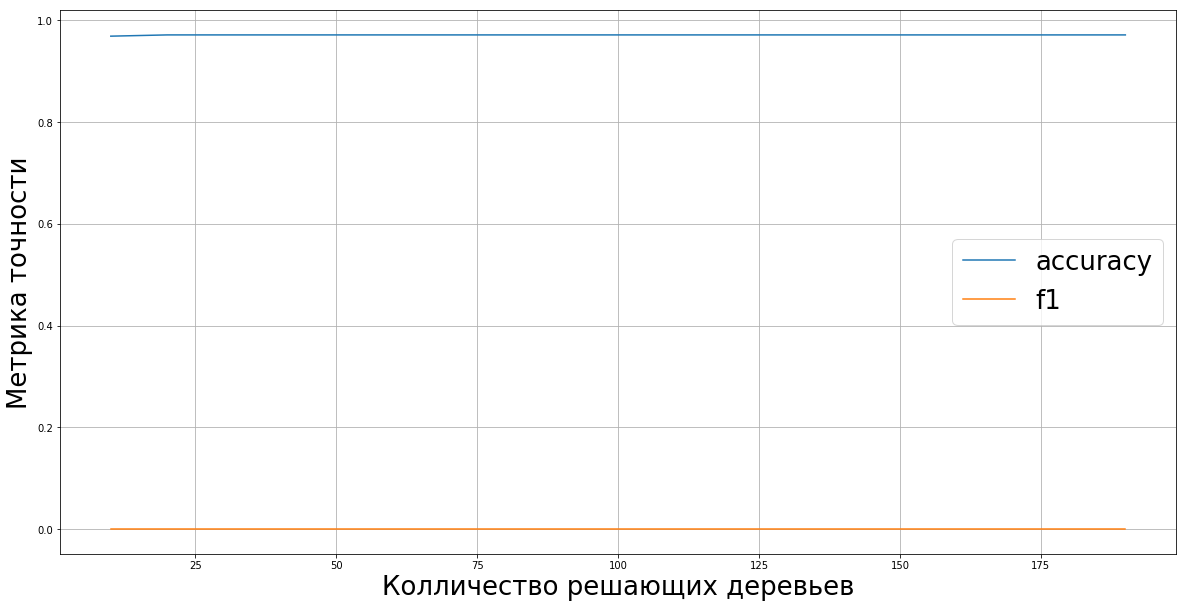

In [54]:
import matplotlib.pyplot as plt
plt.figure(figsize=[20,10])
plt.plot( range(10, 200, 10), acc, label="accuracy")
plt.plot(range(10, 200, 10), f1,  label="f1")
plt.ylabel('Метрика точности', fontsize=26)
plt.xlabel('Колличество решающих деревьев', fontsize=26)
plt.grid()
plt.legend(fontsize=26)
plt.show()

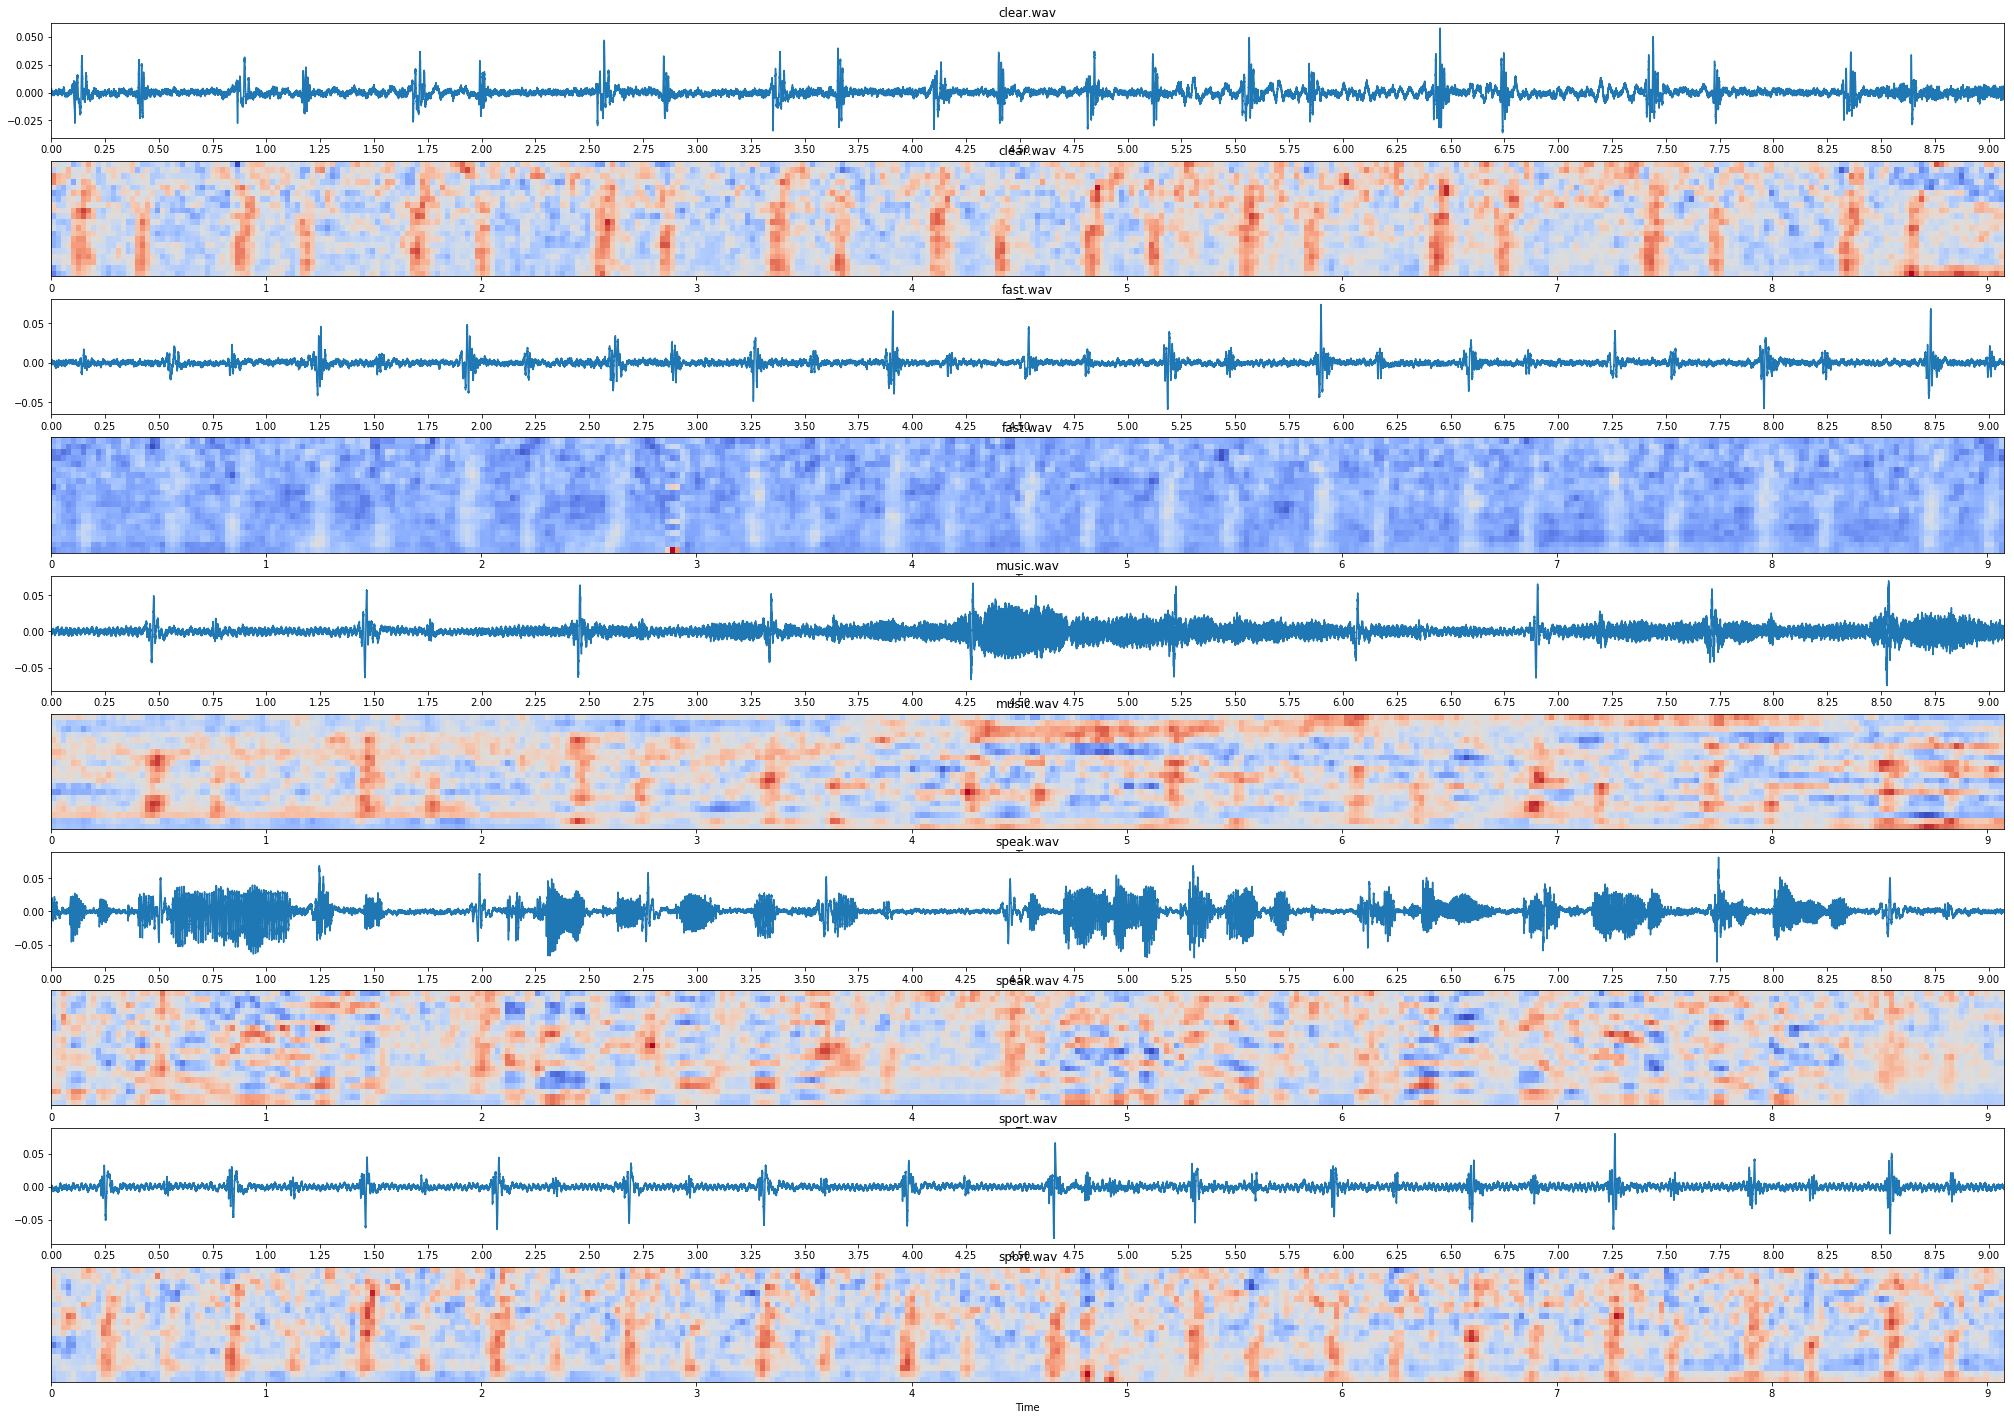

In [16]:
test = Bront(5,1)
files = np.array(os.listdir("data/wav/"))
files = np.delete(files,0)
plt.figure(figsize= [35,25])
st = 500000
en = 700000
time = np.arange(0,(en-st))/22050
for i,file in enumerate(files):
    ax1 =plt.subplot(10, 1, 2*i+1)
    x , sr = librosa.load('data/wav/'+file)
    plt.plot(time,x[st:en])
    plt.xlim(0, time[-1])
    plt.xticks(time[::int(22050/4)])
   # plt.setp(ax1.get_xticklabels(), fontsize=6)
    plt.title(file)
    plt.subplot(10, 1, 2*(i+1))
    librosa.display.specshow(test._mfcc(x[st:en]), x_axis='time')
    
    plt.title(file)
    

In [277]:
input_shape = (20, 24, 1)
output_shape = 1
model = Sequential()
model.add(Conv2D(5, kernel_size=(4, 4),
                 activation='relu',
                 input_shape=input_shape))
model.add(AveragePooling2D((2, 2)))
# Второй сверточный блок
model.add(Conv2D(16, kernel_size=(3, 3),
                 activation='relu'))
model.add(AveragePooling2D((2, 2)))
# Разворачиваем изображение в вектор
model.add(Flatten())
# Полносвязные слои
#model.add(layers.SimpleRNN(128, activation = 'relu'))
model.add(Dense(units=120, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(Dense(units=84, activation='relu'))
#model.add(LSTM(128,activation = 'relu'))
model.add(Dense(units=output_shape, activation = 'relu'))
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss =tf.keras.losses.BinaryCrossentropy(), 
              metrics=['acc','mse'])

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 17, 21, 5)         85        
_________________________________________________________________
average_pooling2d_15 (Averag (None, 8, 10, 5)          0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 6, 8, 16)          736       
_________________________________________________________________
average_pooling2d_16 (Averag (None, 3, 4, 16)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 192)               0         
_________________________________________________________________
dense_70 (Dense)             (None, 120)               23160     
_________________________________________________________________
dropout_11 (Dropout)         (None, 120)             

In [279]:
test, train, target_test, target_train = train_test_split(data_1.reshape([-1,20, 24,1]), target_1, train_size=0.8,shuffle = False)
model.fit(train, target_train, epochs=10 )
prediction = model.predict(test)
#f1_score(prediction,target_test)#, accuracy_score(prediction,target_test)
(target_test-prediction.flatten()).max()

Epoch 1/10
544/544 [==============================] - 0s 303us/step - loss: 0.5072 - acc: 0.1305 - mse: 0.0162
Epoch 2/10
544/544 [==============================] - 0s 465us/step - loss: 0.5104 - acc: 0.1379 - mse: 0.0125
Epoch 3/10
544/544 [==============================] - 0s 577us/step - loss: 0.5109 - acc: 0.1379 - mse: 0.0142
Epoch 4/10
544/544 [==============================] - 0s 549us/step - loss: 0.5620 - acc: 0.1360 - mse: 0.0300
Epoch 5/10
544/544 [==============================] - 0s 442us/step - loss: 0.5466 - acc: 0.1360 - mse: 0.0295
Epoch 6/10
544/544 [==============================] - 0s 498us/step - loss: 0.5168 - acc: 0.1379 - mse: 0.0169
Epoch 7/10
544/544 [==============================] - 0s 393us/step - loss: 0.5076 - acc: 0.1379 - mse: 0.0146
Epoch 8/10
544/544 [==============================] - 0s 415us/step - loss: 0.5128 - acc: 0.1379 - mse: 0.0132
Epoch 9/10
544/544 [==============================] - 0s 628us/step - loss: 0.5066 - acc: 0.1379 - mse: 0.0133
E

0.3165868914273491

Обучение на выделенных данных 

зарисовка мел коэффициентов

In [3]:

for i in data_2:
    librosa.display.specshow(i)
    plt.show()

NameError: name 'data_2' is not defined

формирование данных

In [5]:
name = 'clear'

In [6]:
def data_prep(name, wide_w= 12288, st= 512):
    new_era = Bront(1,1)
    start_mr, end_mr = new_era._get_mark("data/marks/source/"+name+"__mark.txt")
    pcm,sr = librosa.load("data/wav/"+name+".wav")
    bag_range = range(0,pcm.shape[0], st)
    test_mark_1 = np.zeros(len(bag_range))
    k = 0
    for i,i_step in enumerate(bag_range):
        if end_mr[k]<i_step:
            k+=1
            if k>=end_mr.shape[0]:
                break
        pr_1 = 1- (max(i_step-start_mr[k], 0)+
                   max(0, end_mr[k]- i_step-wide_w))/(end_mr[k]- start_mr[k])
            
        if (k+1)<end_mr.shape[0]:
            pr_2 = 1- (max(i_step-start_mr[k+1], 0)+
                       max(end_mr[k+1]- i_step-wide_w, 0))/(end_mr[k+1]- start_mr[k+1]) 
        else :
            pr_2 = 0
        test_mark_1[i]= max(0., pr_1, pr_2)
    ((end_mr - start_mr)).max()
    
    data_1 = np.load("data/dt_1/"+name+"__mfcc__data.npy")#.reshape([-1,120])
    return data_1, test_mark_1
    

data_1, test_mark_1 = data_prep('clear')
true_data_2 = data_1[test_mark_1==1][4::8][:40]
true_target = np.ones(true_data_2.shape[0])
false_data_2 = data_1[test_mark_1<0.2][:40]
false_target = np.zeros(false_data_2.shape[0])
data_2 = np.concatenate((true_data_2, false_data_2), axis=0)
target_2 =  np.concatenate((true_target, false_target), axis=0)
data_2.shape, target_2.shape
data_1_flat = data_1.reshape(-1,480)
    

In [7]:
data_1 = np.load("data/dt_1/"+name+"__mfcc__data.npy")#.reshape([-1,120])
target_1 = test_mark_1
data_1.shape, target_1.shape

((2716, 20, 24), (2716,))

In [7]:
test_drive = Bront(24,1)
path_wav = "data/wav/"
path_features_save = "data/feat_1/"
test_drive.feature_ex_and_safe(path_wav , path_features_save)
test_drive.data_maker("data/feat_1/","data/dt_1/")

data/feat_1/chips__mfcc.npy
data/feat_1/clear__mfcc.npy
data/feat_1/clear_1__mfcc.npy
data/feat_1/fast__mfcc.npy
data/feat_1/music__mfcc.npy
data/feat_1/speak__mfcc.npy
data/feat_1/sport__mfcc.npy
data/dt_1/chips__mfcc__data.npy
data/dt_1/clear_1__mfcc__data.npy
data/dt_1/clear__mfcc__data.npy
data/dt_1/fast__mfcc__data.npy
data/dt_1/music__mfcc__data.npy
data/dt_1/speak__mfcc__data.npy
data/dt_1/sport__mfcc__data.npy


In [8]:
true_data_2 = data_1[target_1==1][4::8][:40]
true_target = np.ones(true_data_2.shape[0])
false_data_2 = data_1[target_1<0.2][:40]
false_target = np.zeros(false_data_2.shape[0])
data_2 = np.concatenate((true_data_2, false_data_2), axis=0)
target_2 =  np.concatenate((true_target, false_target), axis=0)
data_2.shape, target_2.shape
data_1_flat = data_1.reshape(-1,480)

In [8]:
names = ['clear', 'music', 'fast', "clear_1"]
full_data = np.empty([0,480])
full_target = np.empty([0])
for name in names:
    data_p, target_p = data_prep(name)
    print(data_p.shape, target_p.shape)
    data_flat = data_p.reshape([-1,480])
    print(full_data.shape, data_flat.shape)
    full_data = np.append(full_data, data_flat, axis=0)
    full_target = np.append(full_target, target_p)

(2716, 20, 24) (2716,)
(0, 480) (2716, 480)
(5074, 20, 24) (5074,)
(2716, 480) (5074, 480)
(2689, 20, 24) (2689,)
(7790, 480) (2689, 480)
(1292, 20, 24) (1292,)
(10479, 480) (1292, 480)


In [10]:
print(full_data.shape[0]+2707, data_flat.shape)

14478 (1292, 480)


подключение библиотек

In [11]:
import sklearn
from sklearn.model_selection import train_test_split  
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc


Градиентный бустинг 

In [87]:
from sklearn.ensemble import GradientBoostingClassifier
test, train, target_test, target_train = train_test_split(full_data, (full_target==1), train_size=0.9,shuffle =True)
GB_model = GradientBoostingClassifier()
GB_model.fit(train, target_train)
predict_gbc = GB_model.predict(test)
f1_score(predict_gbc,target_test), accuracy_score(predict_gbc,target_test)

(0.7279511533242876, 0.9242896252242047)

К-ближайщих соседей 

In [121]:
from sklearn.neighbors import KNeighborsClassifier
test, train, target_test, target_train = train_test_split(data_2.reshape([-1,480]), target_2, train_size=0.2,shuffle =True)
model_KNC = KNeighborsClassifier(n_neighbors= 3).fit(train,target_train)
predict_knc = model_KNC.predict(test)
f1_score(predict_knc,target_test), accuracy_score(predict_knc,target_test)

(1.0, 1.0)

2
Wall time: 7.93 s
3
Wall time: 7.9 s
4
Wall time: 8.02 s
5
Wall time: 8.05 s
6
Wall time: 7.62 s
7
Wall time: 7.78 s
8
Wall time: 7.9 s
9
Wall time: 7.56 s
10
Wall time: 8.38 s
11
Wall time: 7.86 s
12
Wall time: 7.71 s
13
Wall time: 7.82 s
14
Wall time: 8.58 s
0.828985507246377 5 0.9565537555228277 5


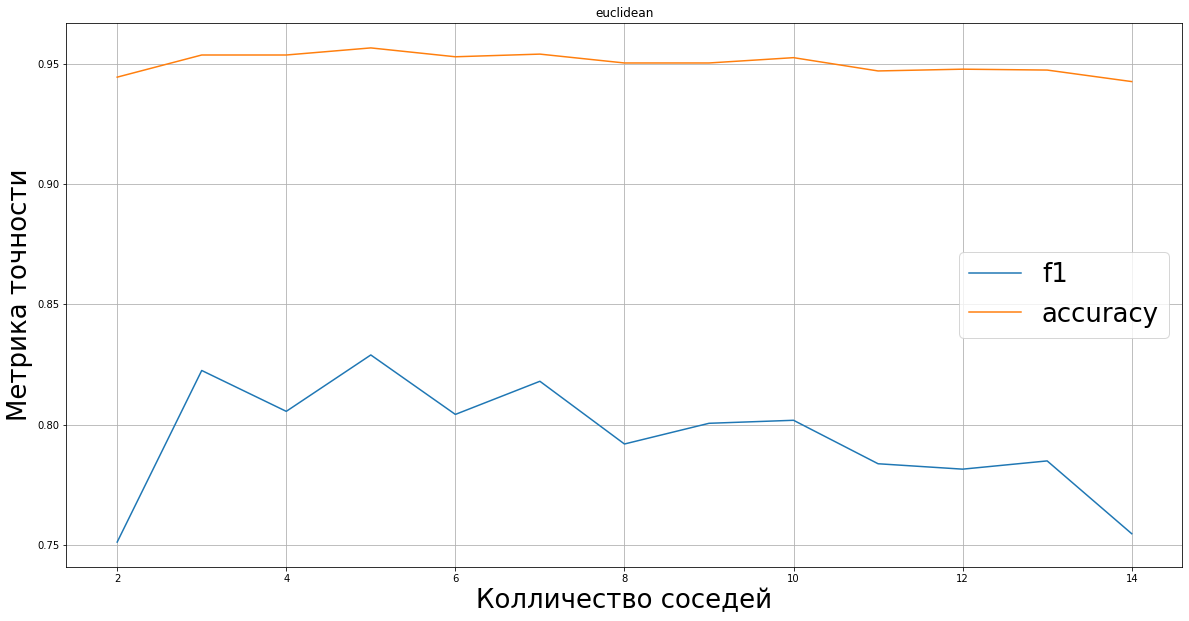

2
Wall time: 7.32 s
3
Wall time: 6.78 s
4
Wall time: 7.14 s
5
Wall time: 6.67 s
6
Wall time: 7.28 s
7
Wall time: 6.16 s
8
Wall time: 6.21 s
9
Wall time: 6.52 s
10
Wall time: 6.18 s
11
Wall time: 6.7 s
12
Wall time: 6.51 s
13
Wall time: 7.02 s
14
Wall time: 6.47 s
0.8364688856729378 7 0.9583946980854198 7


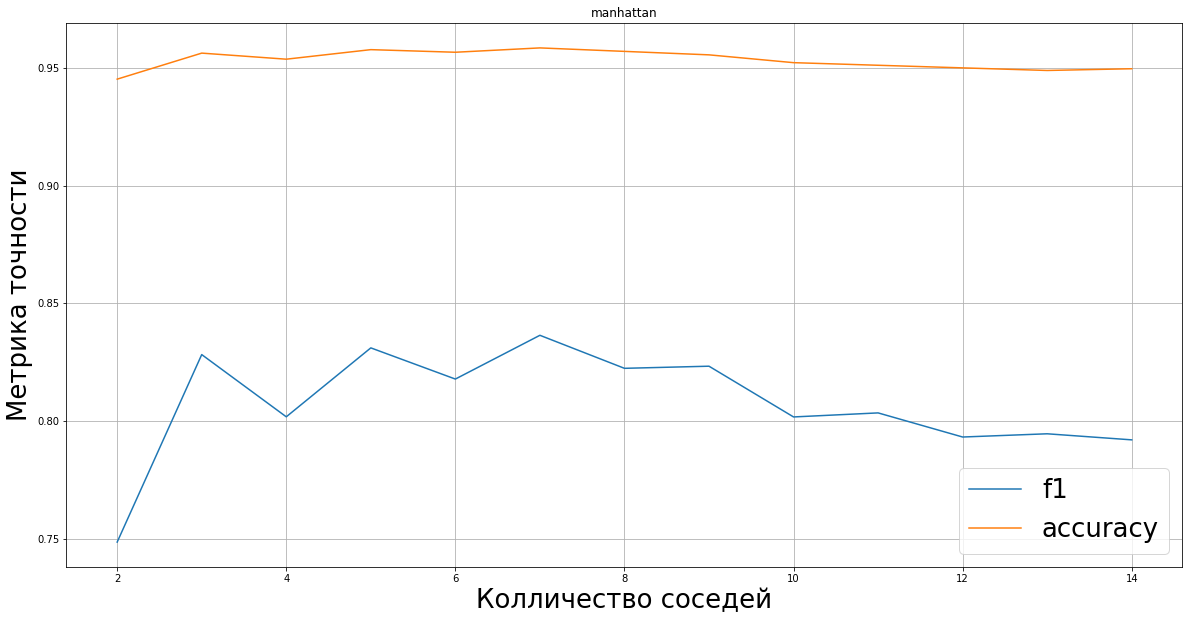

2
Wall time: 9.17 s
3
Wall time: 8.87 s
4
Wall time: 9.74 s
5
Wall time: 9.4 s
6
Wall time: 9.23 s
7
Wall time: 9.71 s
8
Wall time: 11 s
9
Wall time: 9.08 s
10
Wall time: 9.3 s
11
Wall time: 9.02 s
12
Wall time: 9.28 s
13
Wall time: 9.56 s
14
Wall time: 8.41 s
0.6734992679355783 3 0.9230486008836525 2


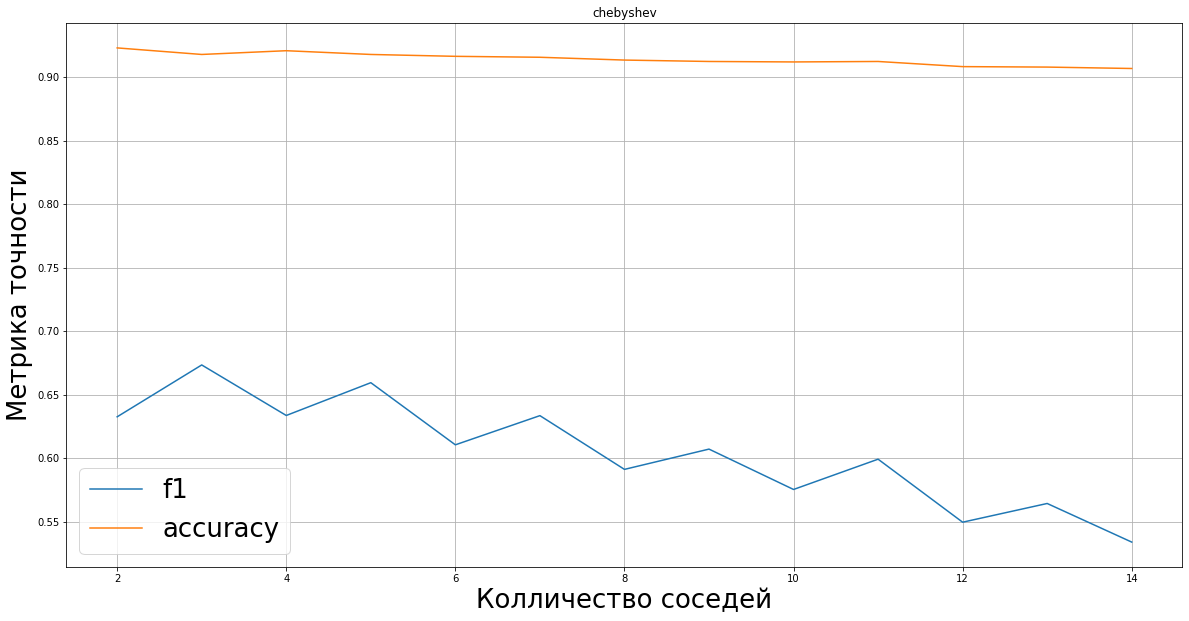

2
Wall time: 7.48 s
3
Wall time: 7.36 s
4
Wall time: 7.38 s
5
Wall time: 7.26 s
6
Wall time: 7.27 s
7
Wall time: 7.39 s
8
Wall time: 7.32 s
9
Wall time: 7.64 s
10
Wall time: 7.39 s
11
Wall time: 7.69 s
12
Wall time: 7.4 s
13
Wall time: 7.7 s
14
Wall time: 7.43 s
0.828985507246377 5 0.9565537555228277 5


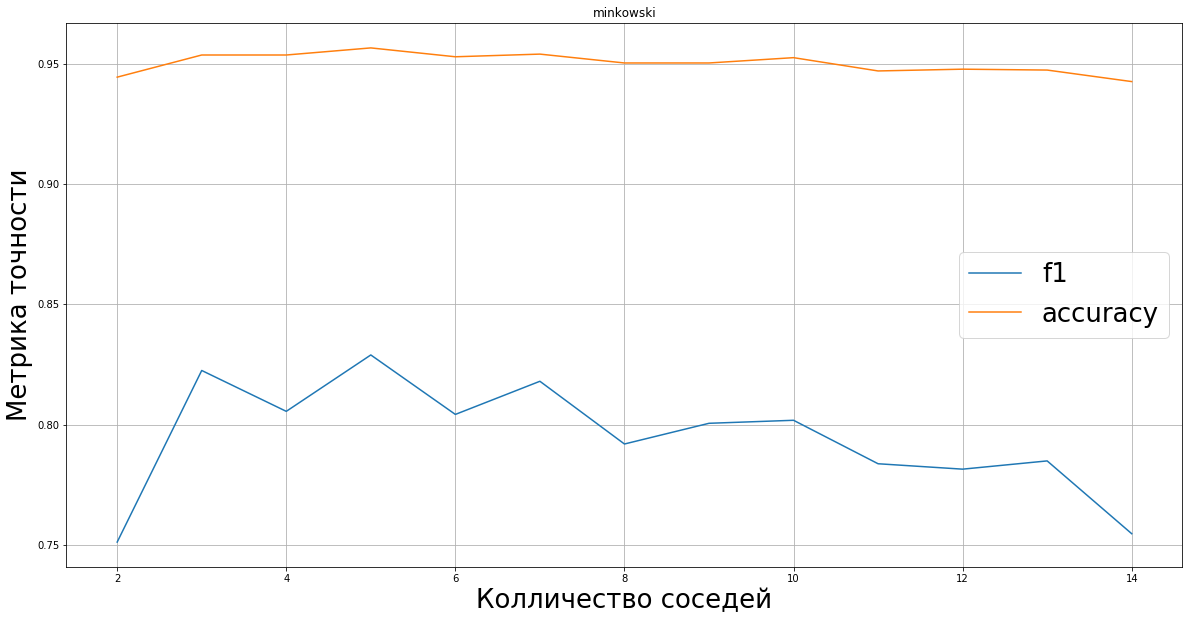

2


TypeError: __init__() takes exactly 1 positional argument (0 given)

In [125]:
%%time
test, train, target_test, target_train = train_test_split(full_data, (full_target==1), train_size=0.8,shuffle =True)
koefs = np.arange(2,15, step=1)
f1 = np.zeros(koefs.shape[0])
acc = np.zeros(koefs.shape[0])
metrics = ['euclidean','manhattan','chebyshev','minkowski','seuclidean','mahalanobis']
for metric in metrics:
    for i,koef in enumerate(koefs):
        print(koef)
        model_KNC1 = KNeighborsClassifier(n_neighbors= koef, metric=metric).fit(train,target_train)
        %time global_pred_knc1 = model_KNC1.predict(data_1_flat)
        f1[i], acc[i] = f1_score(global_pred_knc1,(target_1==1)), accuracy_score(global_pred_knc1,(target_1==1))
    print(f1.max(), koefs[f1.argmax()],acc.max(), koefs[acc.argmax()])
    plt.figure(figsize=[20,10])
    plt.plot(koefs,f1, label="f1")
    plt.plot(koefs, acc, label="accuracy")
    plt.ylabel('Метрика точности', fontsize=26)
    plt.xlabel('Колличество соседей', fontsize=26)
    plt.title(metric)
    plt.grid()
    plt.legend(fontsize=26)
    plt.show()

Обычный персепртон

In [9]:
test, train, target_test, target_train = train_test_split(data_2.reshape([-1,480]), target_2, train_size=0.2,shuffle =True)
test, train, target_test, target_train = train_test_split(full_data, (full_target==1), train_size=0.8,shuffle =True, random_state = 7)
input_shape = (20, 24, 1)
output_shape = 1

model_per = Sequential()

#model.add(layers.SimpleRNN(128, activation = 'relu'))
model_per.add(Dense(units=480, activation='relu'))
model_per.add(Dense(units=240, activation='relu'))
model_per.add(layers.Dropout(0.1))
model_per.add(Dense(units=120, activation='relu'))
model_per.add(layers.Dropout(0.1))
model_per.add(Dense(units=60, activation='relu'))
model_per.add(layers.Dropout(0.1))
#model.add(LSTM(128,activation = 'relu'))
model_per.add(Dense(units=output_shape, activation = 'softplus'))

model_per.compile(keras.optimizers.Adam(), 
              loss =keras.losses.BinaryCrossentropy() 
              #metrics=['acc','mse'])
                 )
#best_model = keras.models.clone_model(model_per)
best_score = 0
koefs = np.arange(0,60, step=1)
f1 = np.zeros(koefs.shape[0])
acc = np.zeros(koefs.shape[0])
for i in range(60):
    model_per.fit(train, target_train, epochs= 1)
    predict_pnn = (model_per.predict(test).flatten())
    f1[i], acc[i] = f1_score(predict_pnn>0.5,(target_test==1)), accuracy_score(predict_pnn>0.5,(target_test==1))
    print(f1.max(), koefs[f1.argmax()],acc.max(), koefs[acc.argmax()])
    #print(f1_score(predict_nn,target_test), accuracy_score(predict_nn,target_test))
    if best_score < f1.max():
        print('!!!')
        weights = model_per.get_weights()
        best_model = tf.keras.models.clone_model(model_per)
        best_score = f1.max()
model_per.summary()

74/74 [==============================] - ETA: 0s - loss: 9.207 - ETA: 0s - loss: 2.066 - ETA: 0s - loss: 1.341 - ETA: 0s - loss: 1.013 - ETA: 0s - loss: 0.902 - ETA: 0s - loss: 0.759 - ETA: 0s - loss: 0.681 - ETA: 0s - loss: 0.611 - ETA: 0s - loss: 0.585 - ETA: 0s - loss: 0.536 - ETA: 0s - loss: 0.508 - ETA: 0s - loss: 0.485 - ETA: 0s - loss: 0.465 - ETA: 0s - loss: 0.465 - 1s 10ms/step - loss: 0.4539
0.8107606679035251 0 0.9350042480883602 0
!!!
74/74 [==============================] - ETA: 0s - loss: 0.063 - ETA: 0s - loss: 0.262 - ETA: 0s - loss: 0.257 - ETA: 0s - loss: 0.233 - ETA: 0s - loss: 0.212 - ETA: 0s - loss: 0.228 - ETA: 0s - loss: 0.204 - ETA: 0s - loss: 0.199 - ETA: 0s - loss: 0.183 - ETA: 0s - loss: 0.180 - ETA: 0s - loss: 0.175 - ETA: 0s - loss: 0.175 - 1s 8ms/step - loss: 0.1755
0.8107606679035251 0 0.9350042480883602 0
74/74 [==============================] - ETA: 0s - loss: 0.205 - ETA: 0s - loss: 0.198 - ETA: 0s - loss: 0.148 - ETA: 0s - loss: 0.128 - ETA: 0s - loss

In [ ]:
# ne trogatb
test

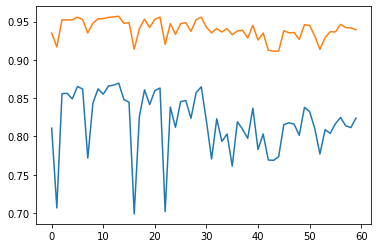

In [10]:
plt.plot(f1)
plt.plot(acc)

In [268]:
best_model.set_weights(weights)
predict_nn = (best_model.predict(test).flatten()>0.53)
print(f1_score(predict_nn,target_test), accuracy_score(predict_nn,target_test))
best_score

0.8545130641330165 0.9537430378551874


0.8545130641330165

In [244]:
best_model.save("best_pnn_2_7.10.20.h5")

In [254]:
lm = keras.models.load_model("best_pnn_1_7.10.20.h5")


In [255]:
lm.compile()

0.8693333333333334 0.54 0.9583722708351032 0.54


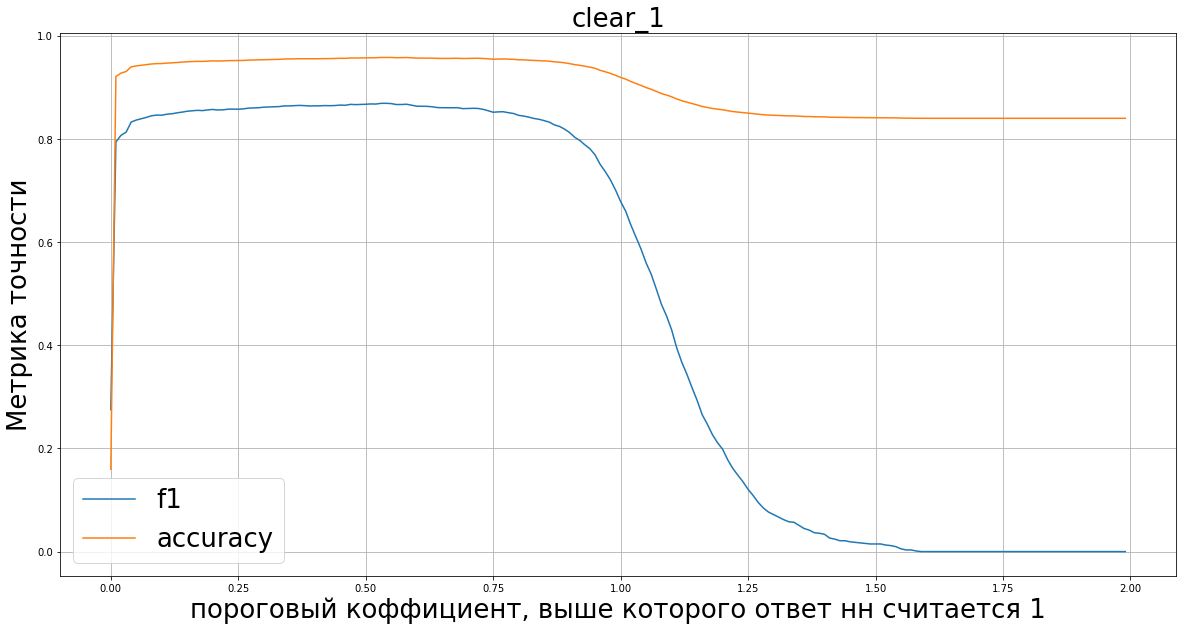

In [269]:
global_pred_nn = best_model.predict(full_data).flatten()
koefs = np.arange(0,2, step=0.01)
f1 = np.zeros(koefs.shape[0])
acc = np.zeros(koefs.shape[0])
for i,koef in enumerate(koefs):
    f1[i], acc[i] = f1_score(global_pred_nn>koef,(full_target==1)), accuracy_score(global_pred_nn>koef,(full_target==1))
print(f1.max(), koefs[f1.argmax()],acc.max(), koefs[acc.argmax()])
plt.figure(figsize=[20,10])
plt.plot(koefs,f1, label="f1")
plt.plot(koefs, acc, label="accuracy")
plt.ylabel('Метрика точности', fontsize=26)
plt.xlabel('пороговый коффициент, выше которого ответ нн считается 1', fontsize=26)
plt.title(name,fontsize=26)
plt.grid()
plt.legend(fontsize=26)
plt.show()

(2716, 20, 24) (2716,)
0.8422535211267607 1.69 0.9591310751104566 3.5700000000000003


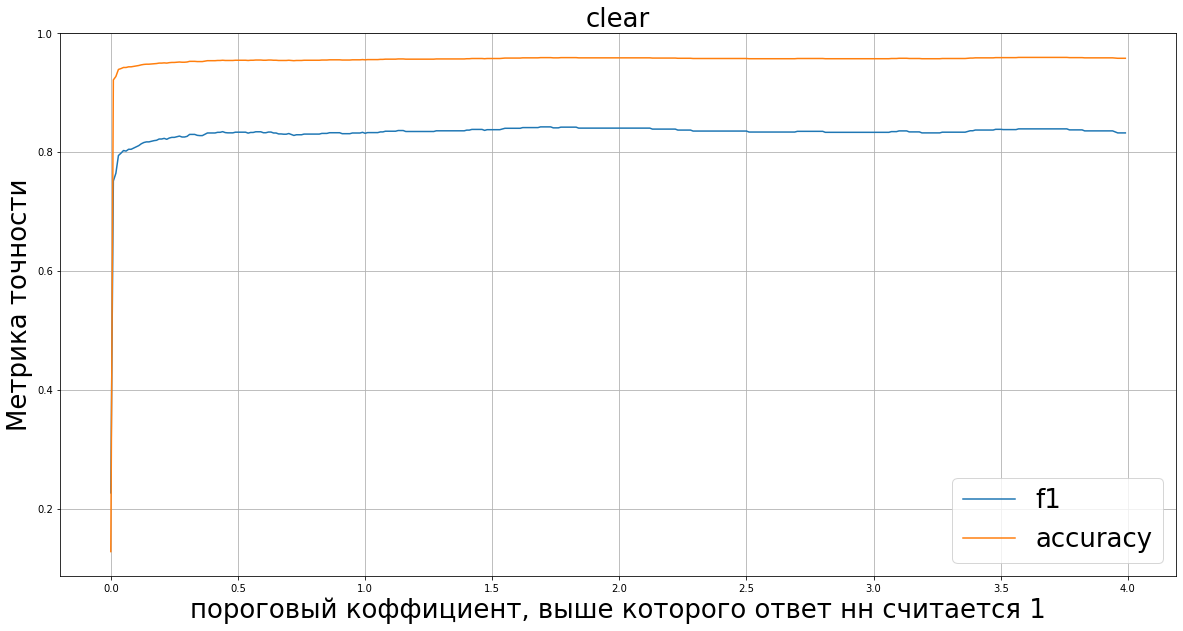

(2707, 20, 24) (2707,)
0.27853736089030207 0.0 0.7787218322866643 3.95


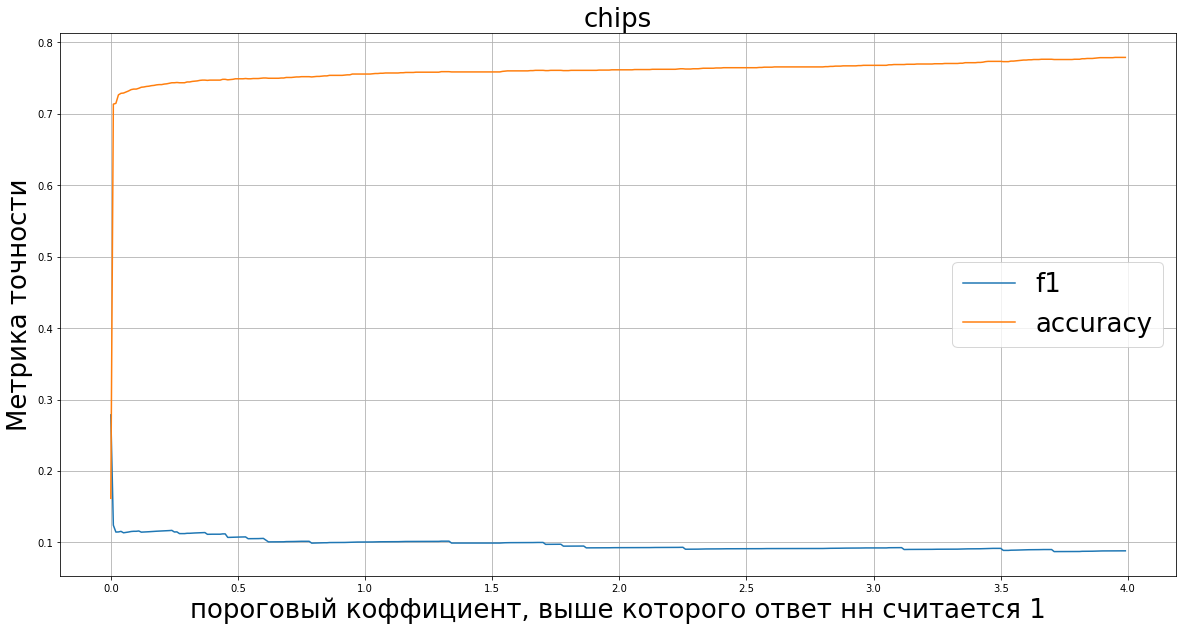

(5074, 20, 24) (5074,)
0.8609188168659534 0.14 0.9568387859676784 0.19


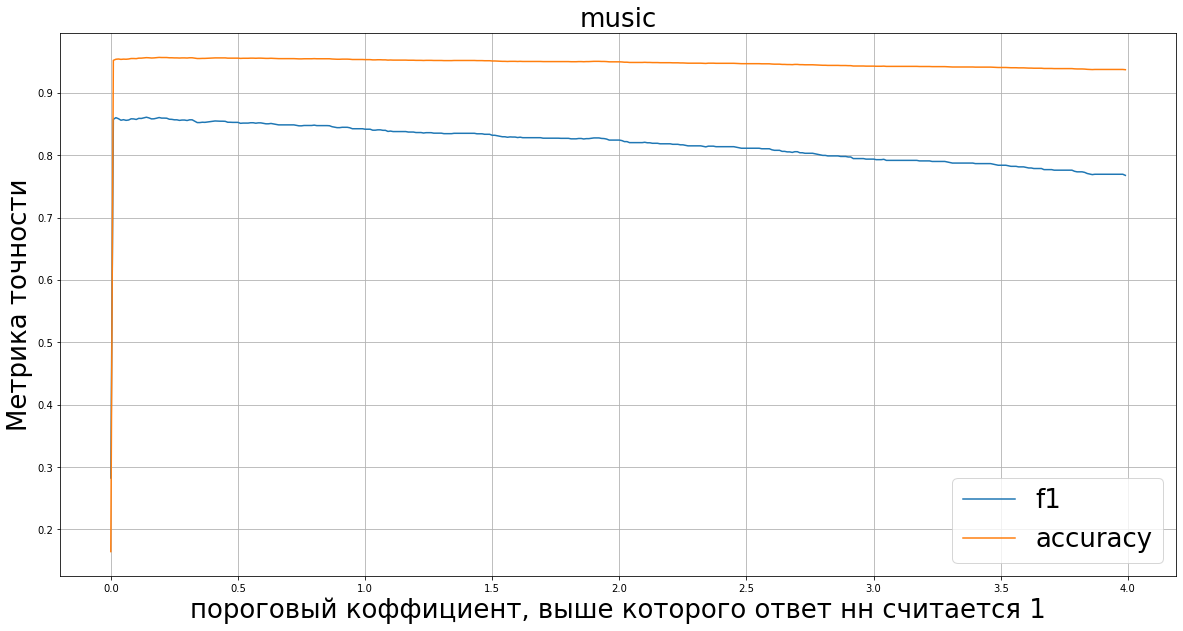

(2689, 20, 24) (2689,)
0.8850102669404517 0.35000000000000003 0.9583488285608033 0.35000000000000003


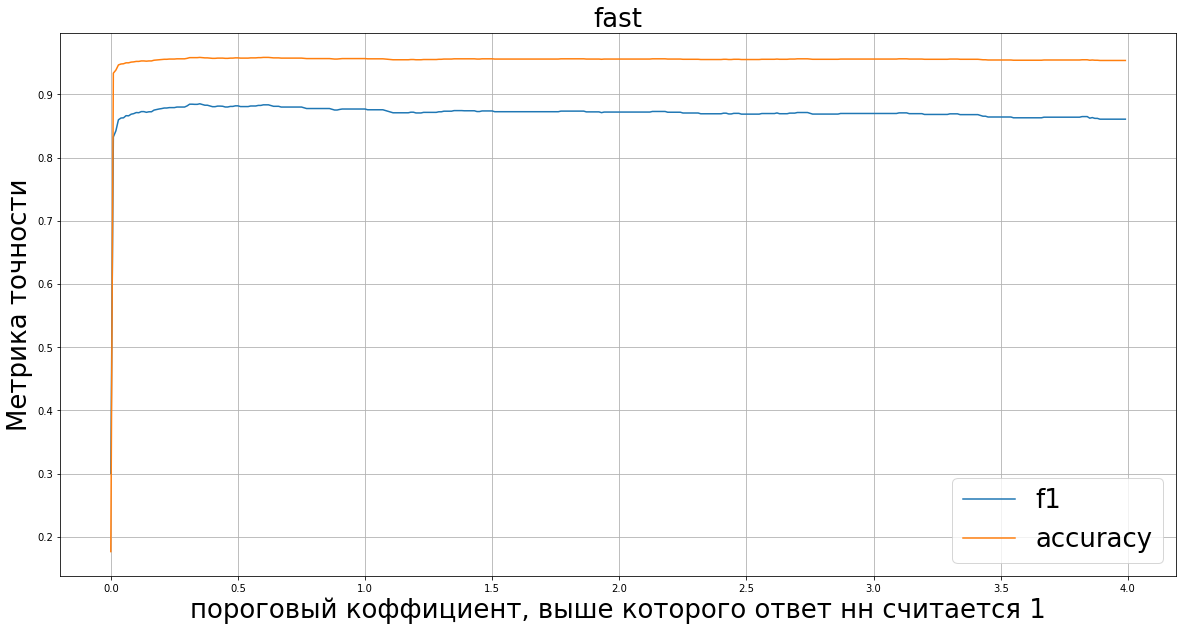

(1292, 20, 24) (1292,)
0.928888888888889 0.18 0.9752321981424149 0.18


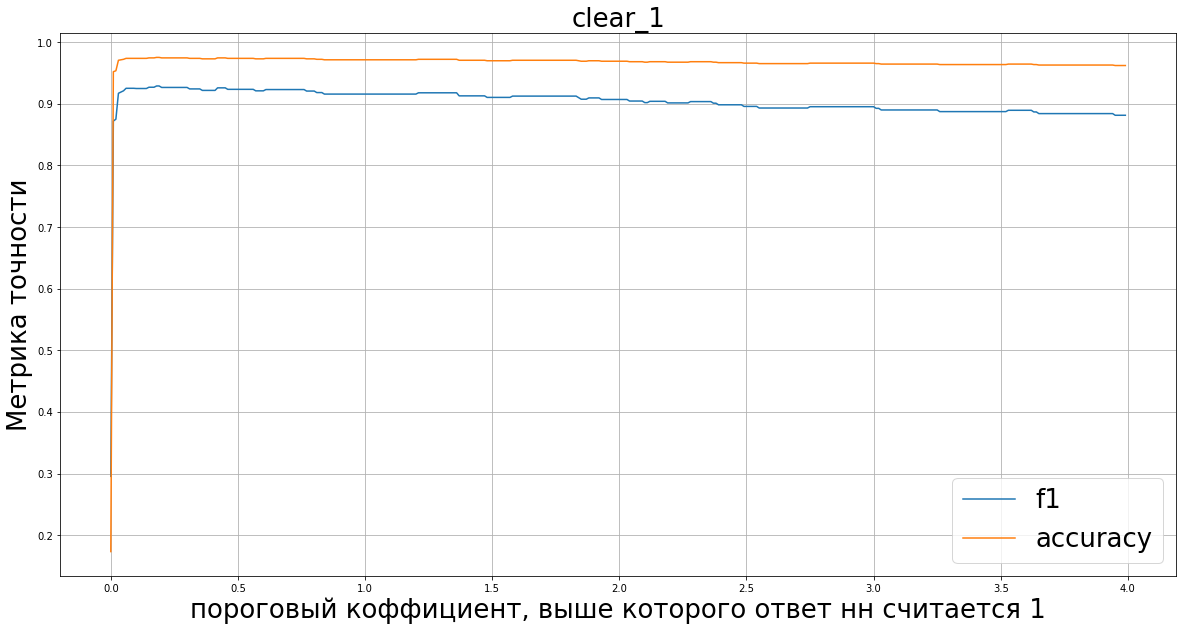

In [260]:
names = ['clear','chips', 'music', 'fast', "clear_1"]
for name in names:
    data_p, target_p = data_prep(name)
    print(data_p.shape, target_p.shape)
    data_flat = data_p.reshape([-1,480])
    global_pred_nn = best_model.predict(data_flat).flatten()
    koefs = np.arange(0,4, step=0.01)
    f1 = np.zeros(koefs.shape[0])
    acc = np.zeros(koefs.shape[0])
    for i,koef in enumerate(koefs):
        f1[i], acc[i] = f1_score(global_pred_nn>koef,(target_p==1)), accuracy_score(global_pred_nn>koef,(target_p==1))
    print(f1.max(), koefs[f1.argmax()],acc.max(), koefs[acc.argmax()])
    plt.figure(figsize=[20,10])
    plt.plot(koefs,f1, label="f1")
    plt.plot(koefs, acc, label="accuracy")
    plt.ylabel('Метрика точности', fontsize=26)
    plt.xlabel('пороговый коффициент, выше которого ответ нн считается 1', fontsize=26)
    plt.title(name,fontsize=26)
    plt.grid()
    plt.legend(fontsize=26)
    plt.show()

In [13]:
model_per.save('model290920.h5')

In [15]:
new_model = tf.keras.models.load_model("model290920.h5")

In [279]:
data_p, target_p = data_prep('music')
print(data_p.shape, target_p.shape)
data_flat = data_p.reshape([-1,480])
local_pred_nn = model_per.predict(data_flat).flatten()

(5074, 20, 24) (5074,)


In [280]:
pcm, sr = librosa.load('data/wav/music.wav')
def demonstration(len_pcm,target_p):
    model_rez_view = np.zeros(len_pcm)
    for i,j in enumerate(np.arange(0,len_pcm-12229,512)):
        for k in range(j,(j+12228)):
            if target_p[i]==1:
                model_rez_view[k] = 1
            elif k>(j+12228-512):
                model_rez_view[k] = 0    
    return model_rez_view
model_rez_view = demonstration(pcm.shape[0], target_p)

In [281]:
model_pred_demon  = demonstration(pcm.shape[0], local_pred_nn>0.5)

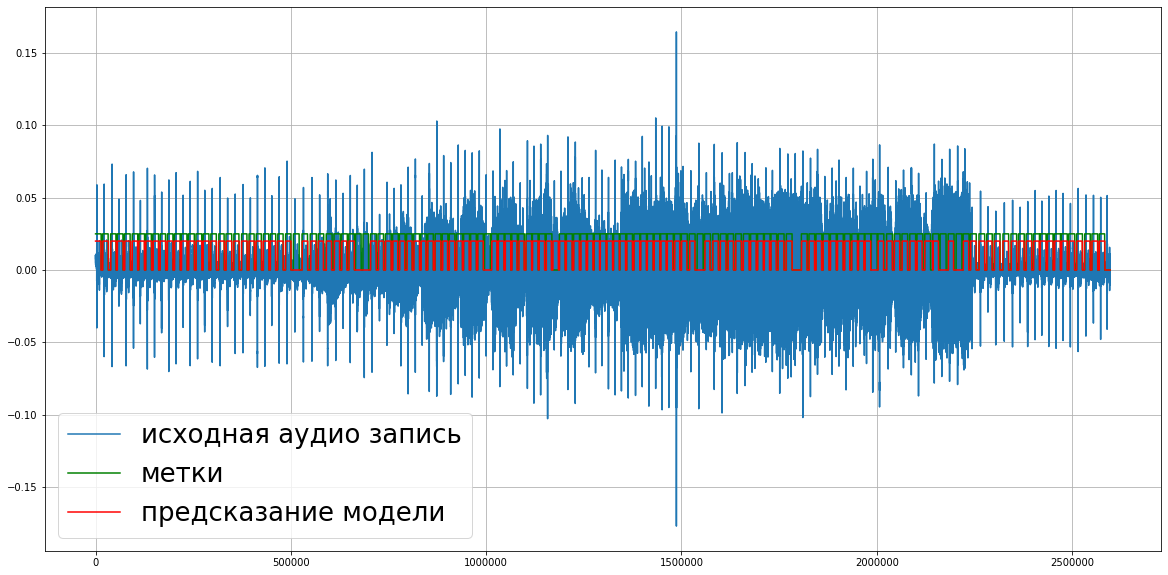

In [293]:

stend = [0,-1]
plt.figure(figsize=[20,10])
plt.plot(pcm[stend[0]:stend[1]], label = "исходная аудио запись" )
plt.plot((model_rez_view*0.025)[stend[0]:stend[1]], label="метки",color='green')
plt.plot((model_pred_demon*0.02)[stend[0]:stend[1]], color='red', label='предсказание модели')
#plt.ylabel('Метрика точности', fontsize=26)
#plt.xlabel('пороговый коффициент, выше которого ответ нн считается 1', fontsize=26)
#plt.title(name,fontsize=26)
plt.grid()
plt.legend(fontsize=26)
plt.show()

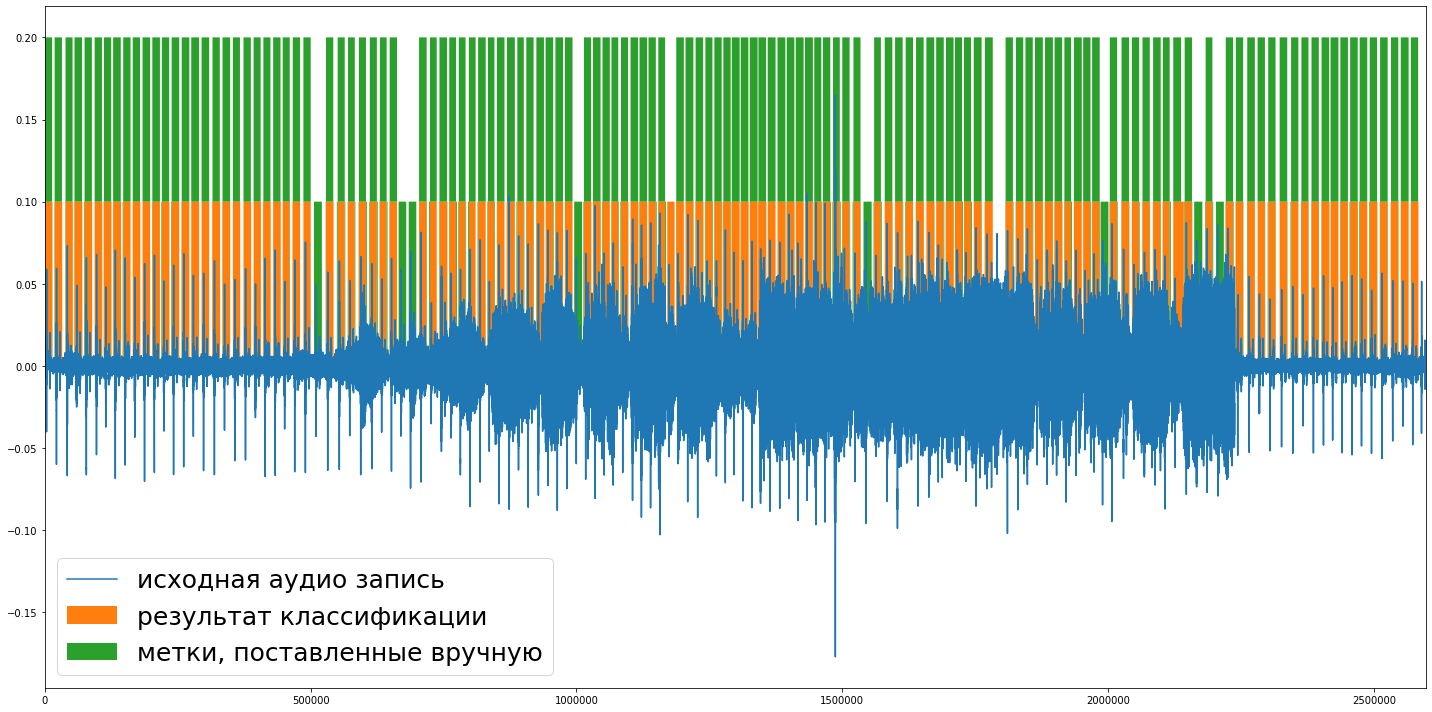

(2, 2597489)

In [294]:
x = (model_rez_view*0.1)[stend[0]:stend[1]]
y = (model_pred_demon*0.1)[stend[0]:stend[1]]
rng = np.arange(x.shape[0])
rnd = np.append(y,x).reshape([2,-1])
yrs = rng

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(pcm[stend[0]:stend[1]], label = "исходная аудио запись")
ax.stackplot(yrs, rnd, labels=[ 'результат классификации','метки, поставленные вручную'])
#ax.set_title('Combined debt growth over time')
ax.legend(fontsize=25, loc='lower left')
#ax.set_ylabel('Total debt')
ax.set_xlim(xmin=yrs[0], xmax=yrs[-1])
fig.tight_layout()

plt.show()
rnd.shape

In [156]:
z = np.append(x,y)
(z.reshape([2,-1])[1]-y).sum()

0.0

Анализ результатов

In [14]:
name = names[0]
data_p, target_p = data_prep(name)
print(data_p.shape, target_p.shape)
data_flat = data_p.reshape([-1,480])
global_pred_nn = model_per.predict(data_flat).flatten()

(2716, 20, 24) (2716,)


In [19]:
pred = global_pred_nn>8.6
tar = (target_p==1)
pred[tar==1].sum()/pred[tar==1].shape[0]

0.8703170028818443

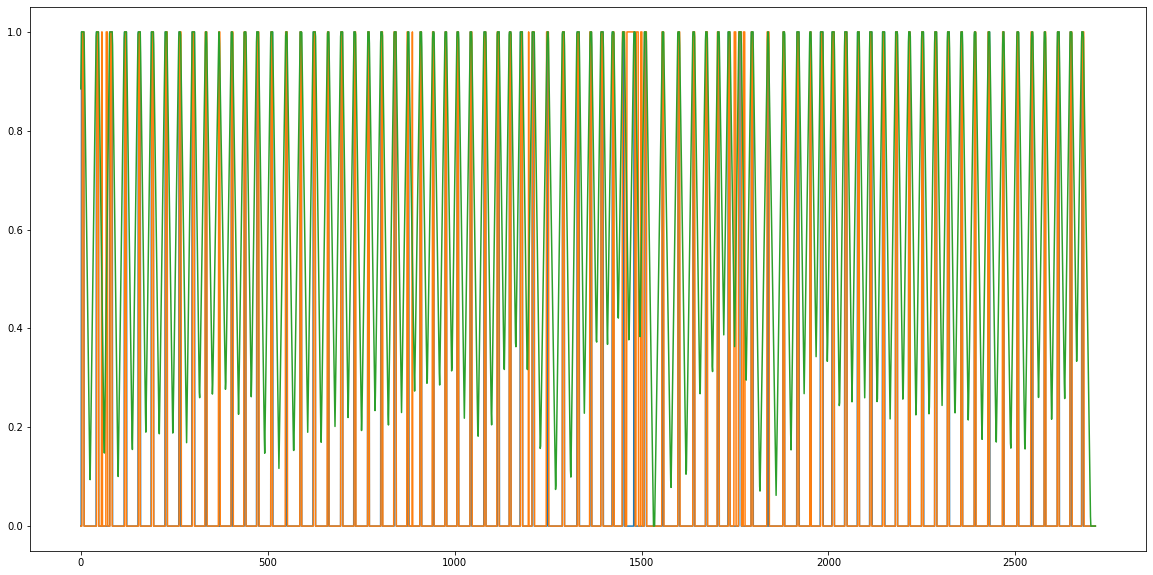

In [28]:
win = [0,-1]
plt.figure(figsize=[20,10])
plt.plot(tar[win[0]:win[1]])
plt.plot(pred[win[0]:win[1]])
plt.plot(target_p[win[0]:win[1]])

In [25]:
n_tar = 0
n_pred = 0
for i in range(1,tar.shape[0]):
    if tar[i]!=tar[i-1]:
        n_tar +=1
    if pred[i]!=pred[i-1]:
        n_pred +=1   
n_pred, n_tar

(170, 154)

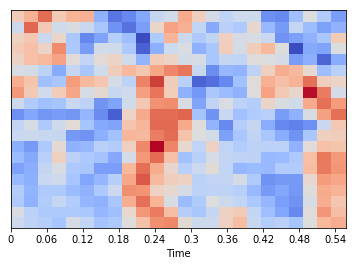

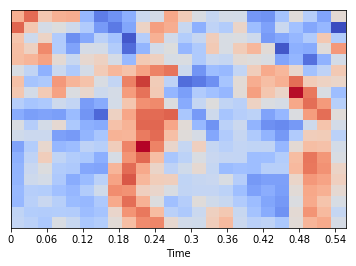

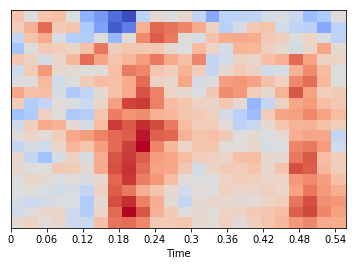

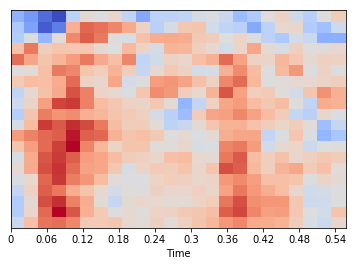

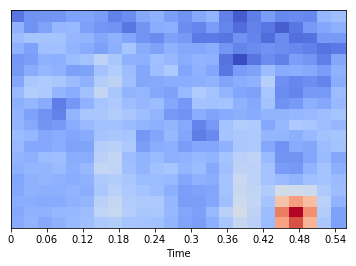

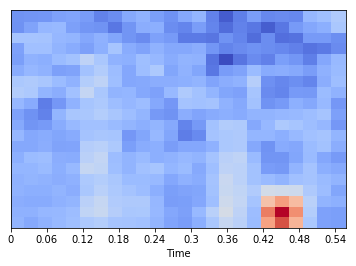

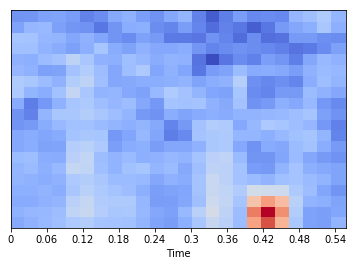

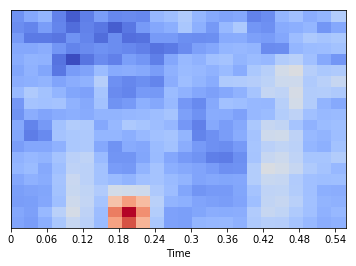

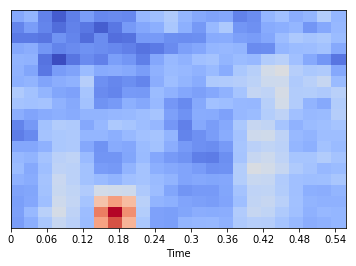

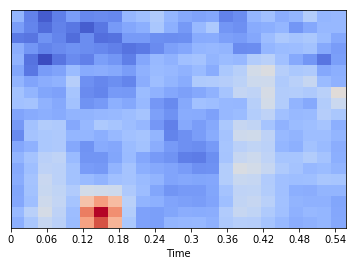

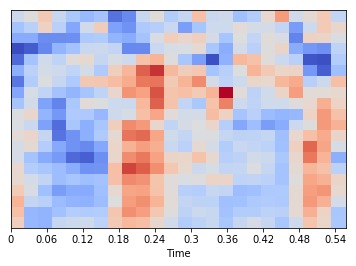

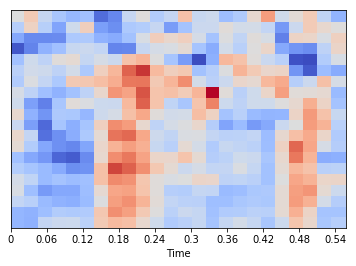

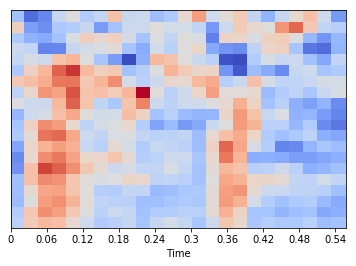

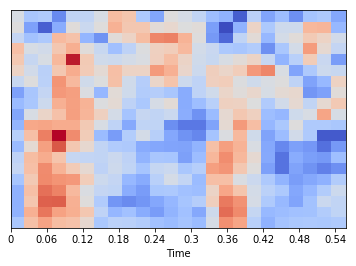

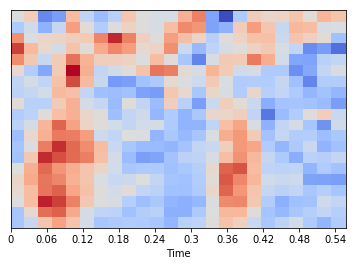

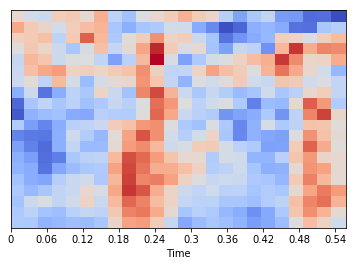

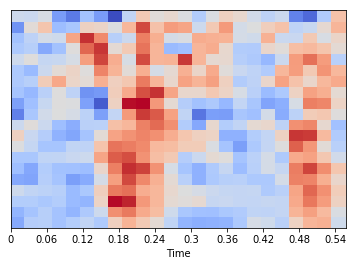

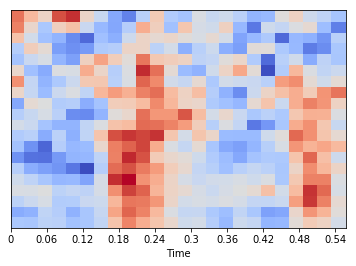

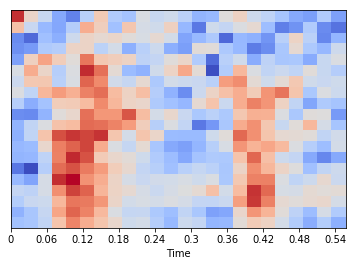

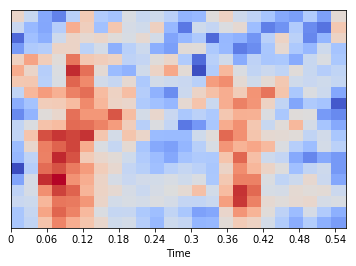

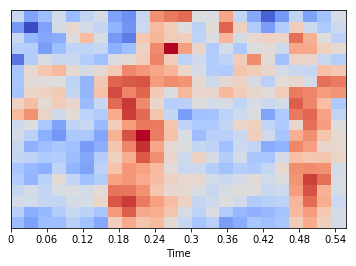

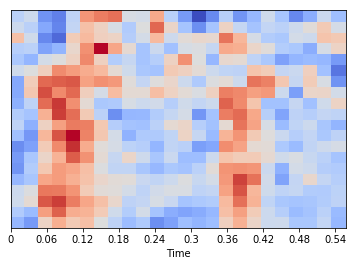

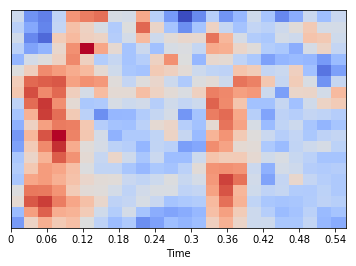

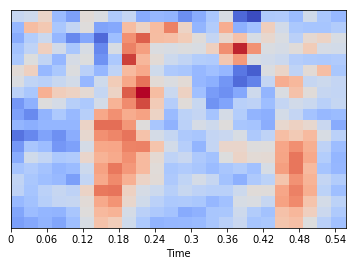

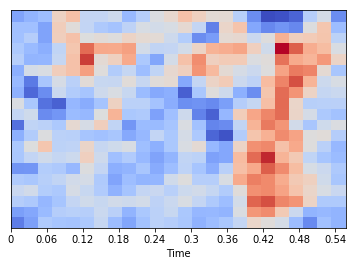

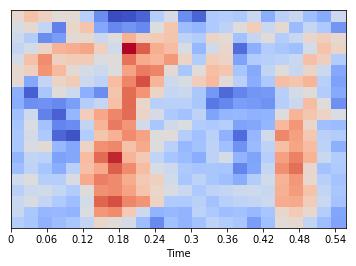

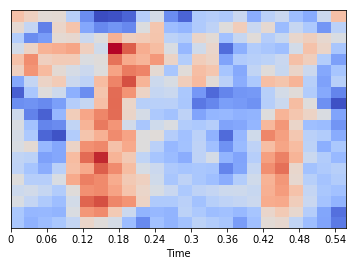

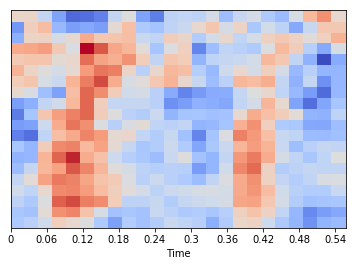

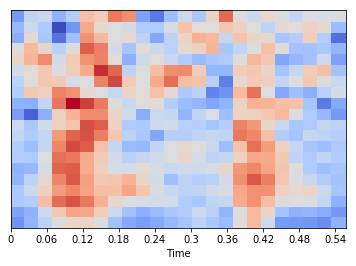

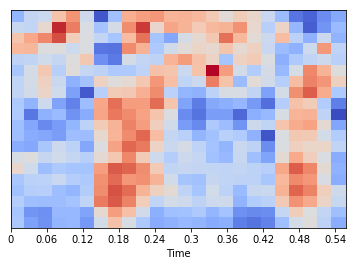

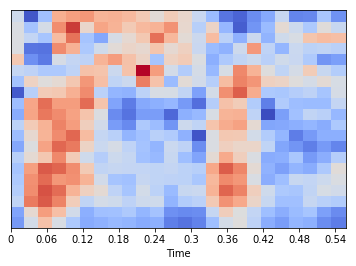

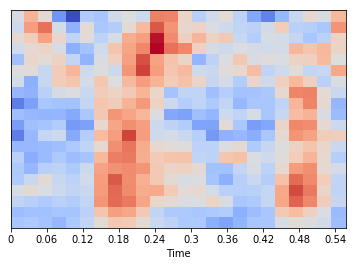

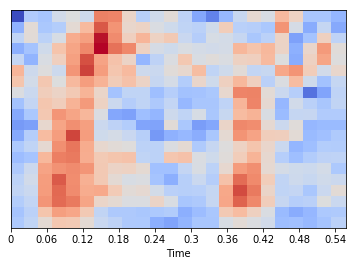

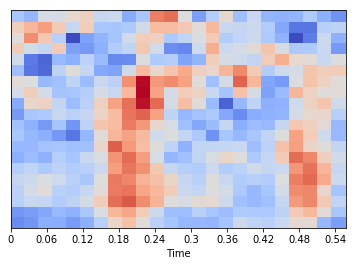

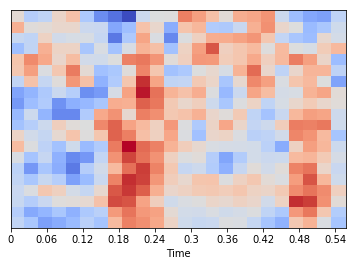

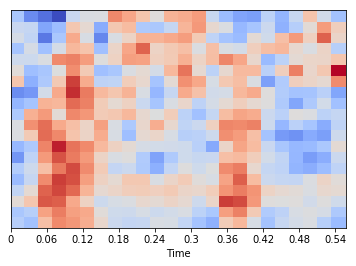

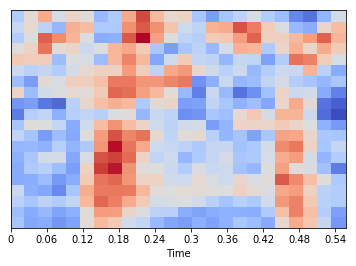

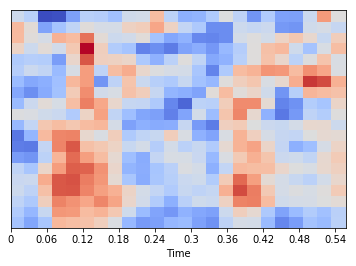

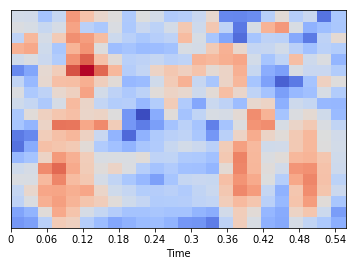

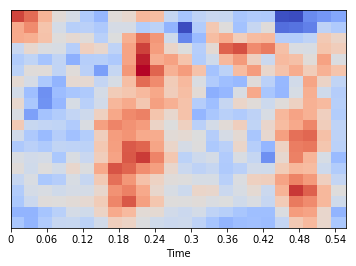

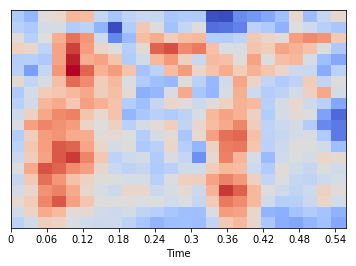

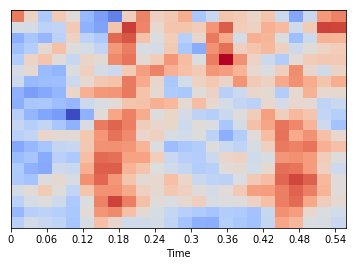

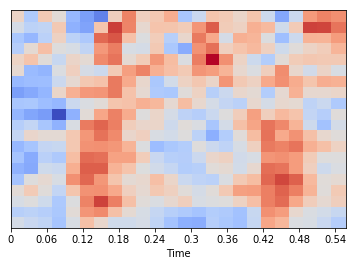

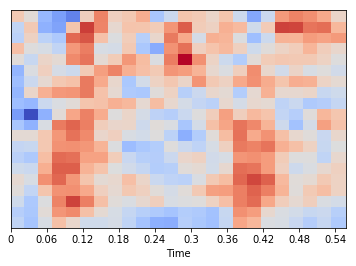

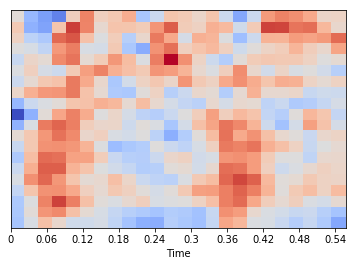

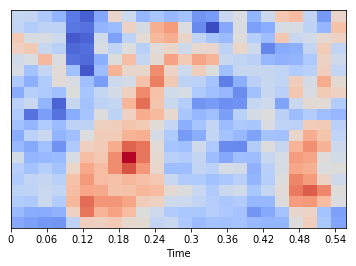

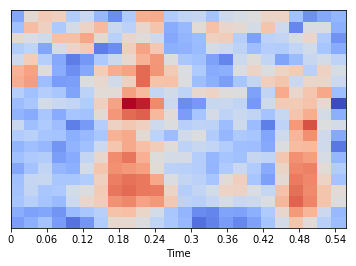

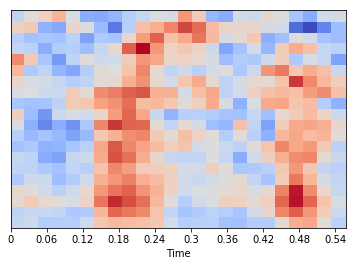

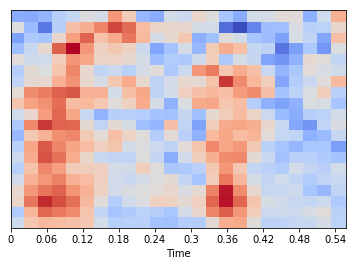

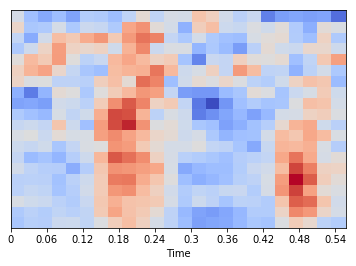

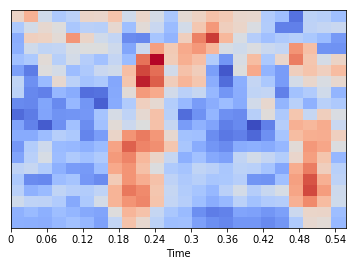

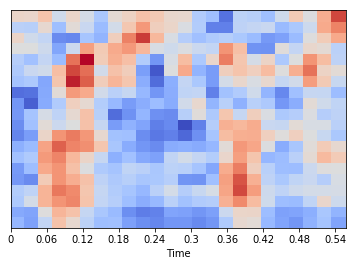

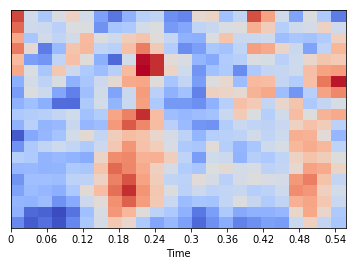

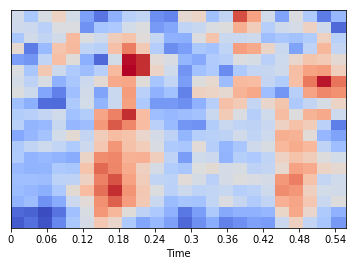

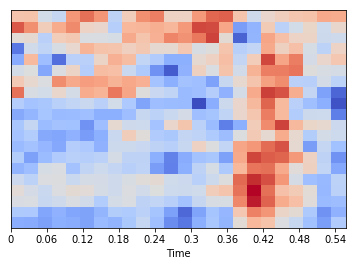

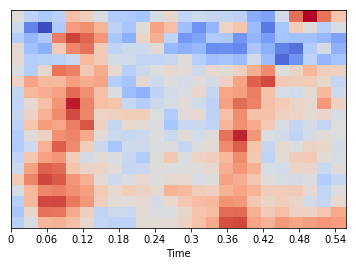

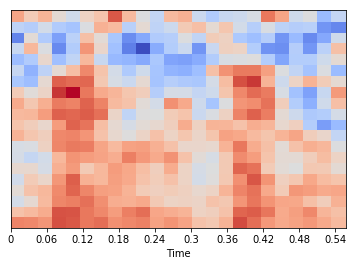

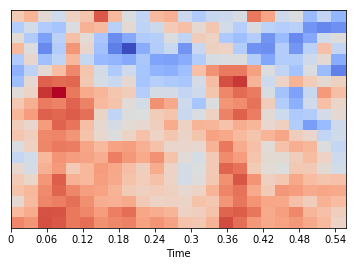

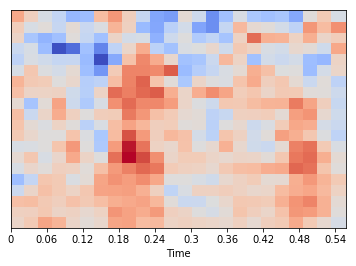

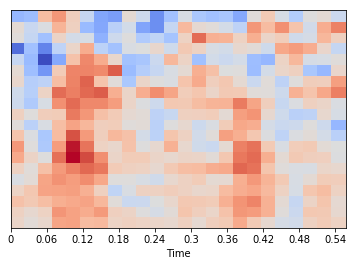

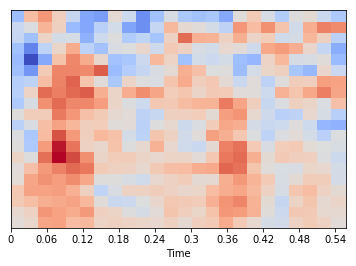

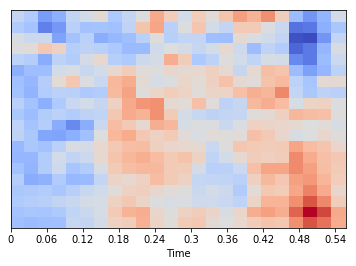

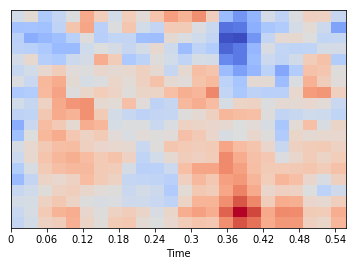

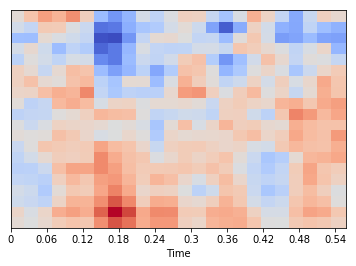

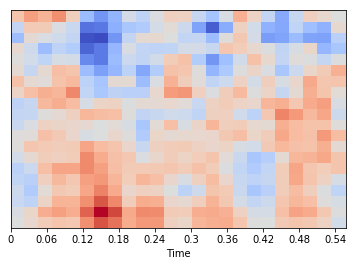

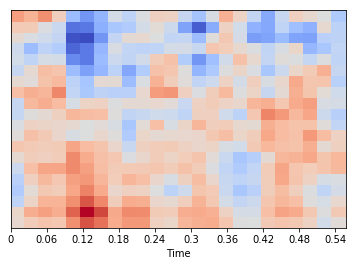

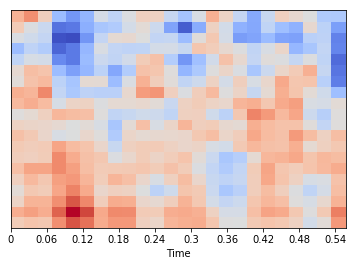

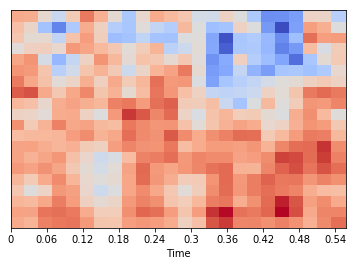

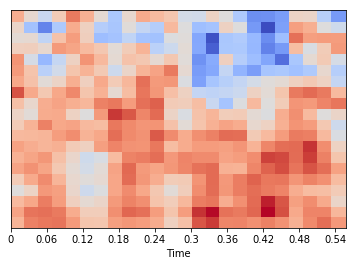

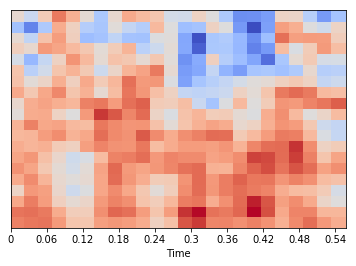

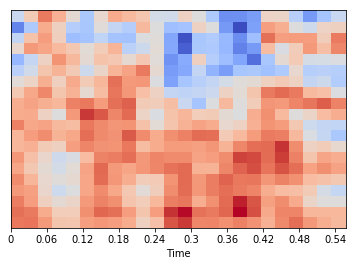

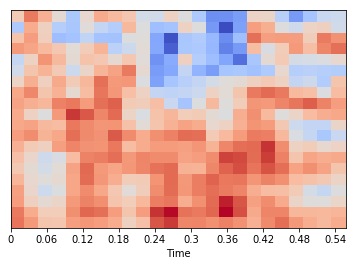

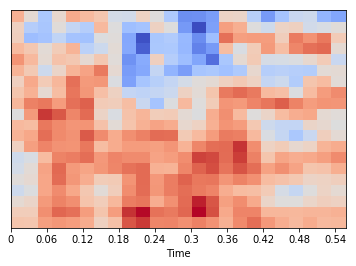

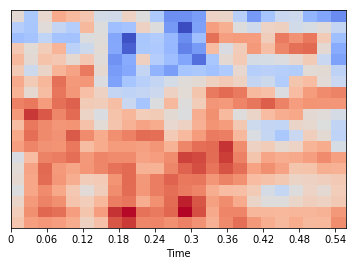

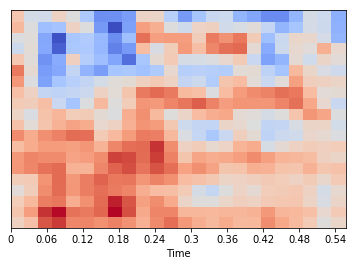

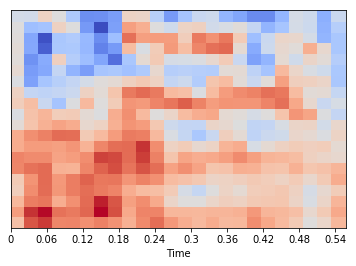

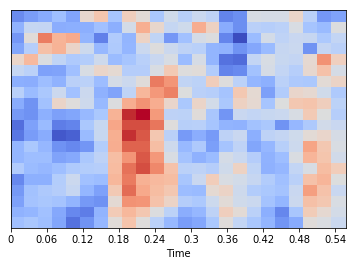

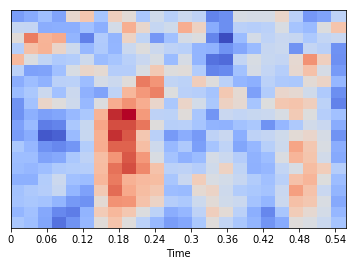

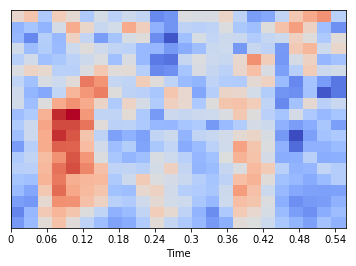

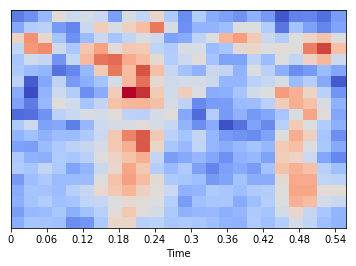

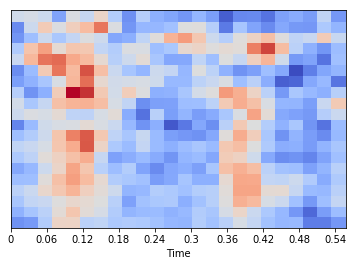

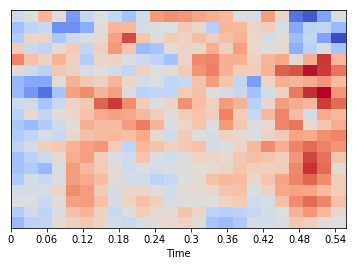

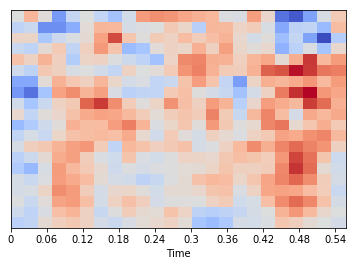

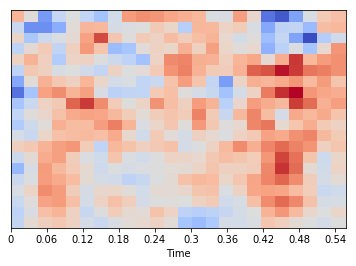

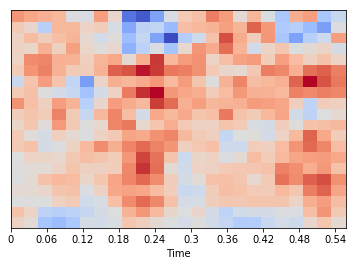

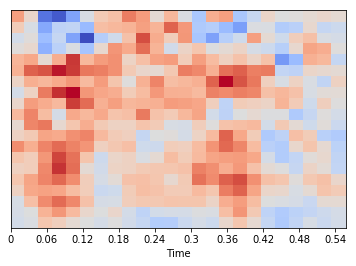

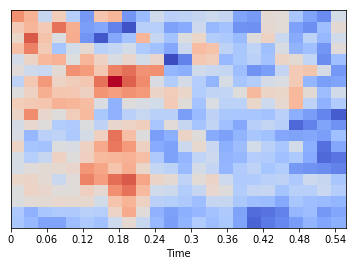

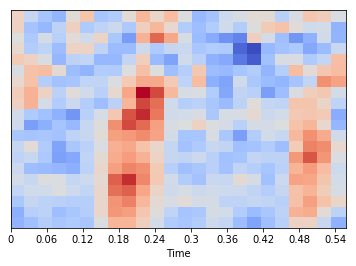

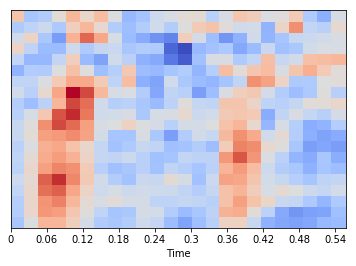

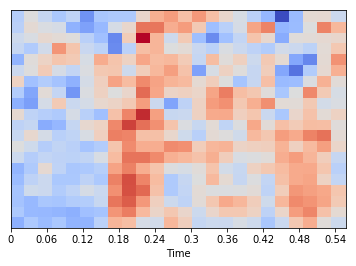

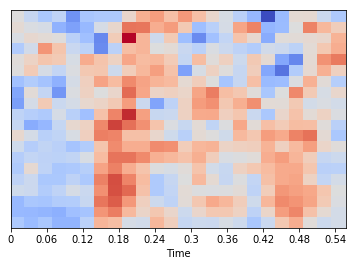

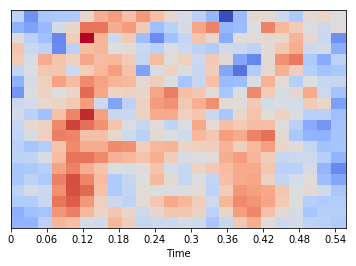

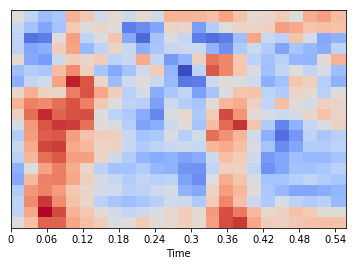

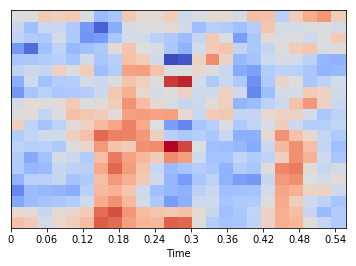

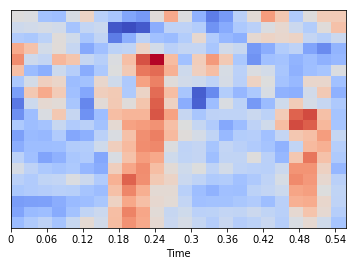

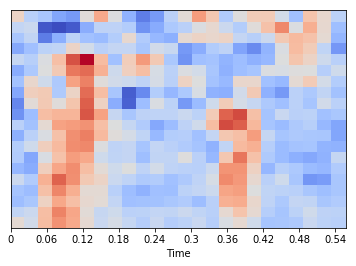

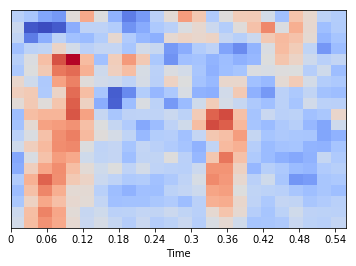

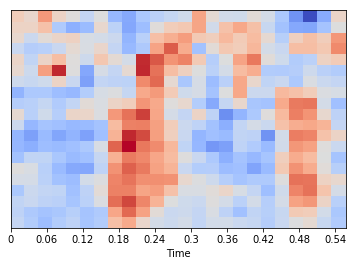

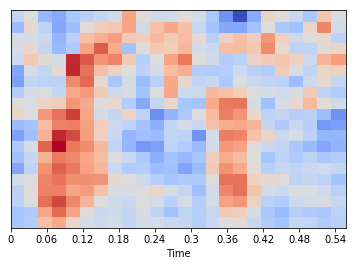

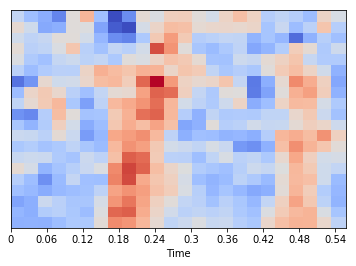

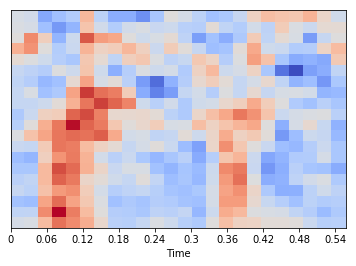

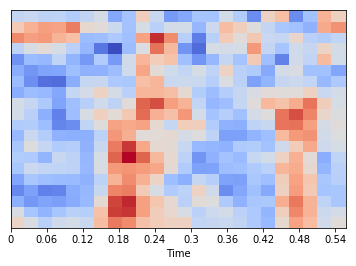

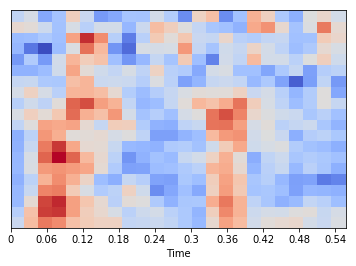

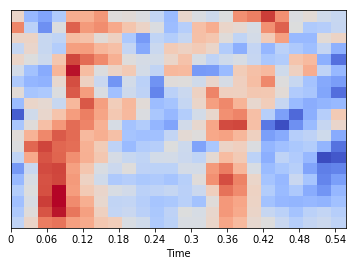

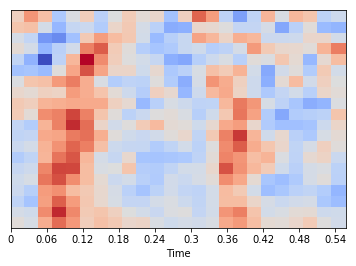

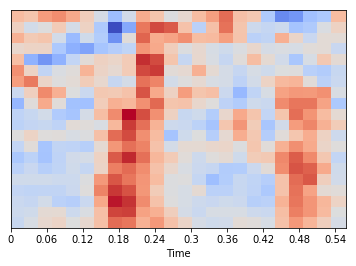

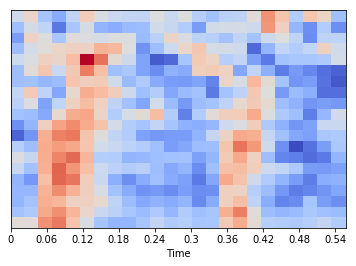

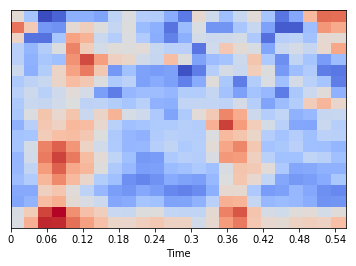

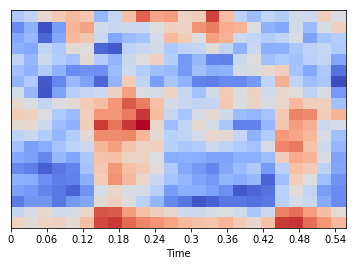

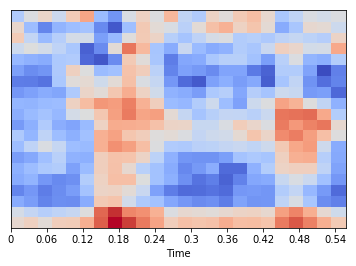

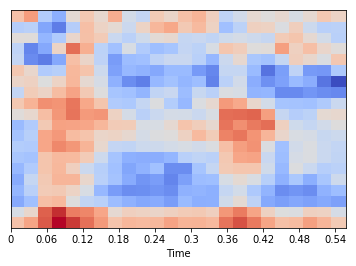

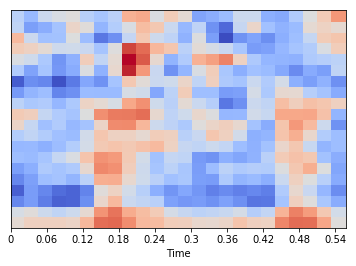

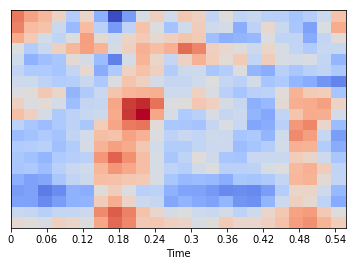

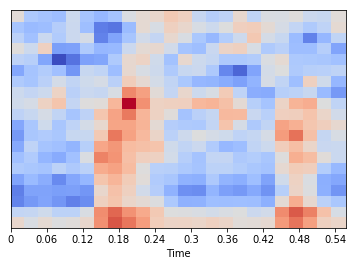

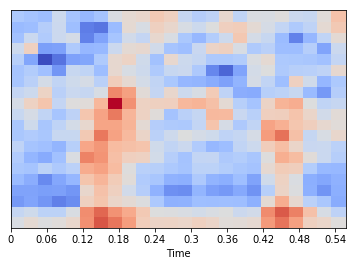

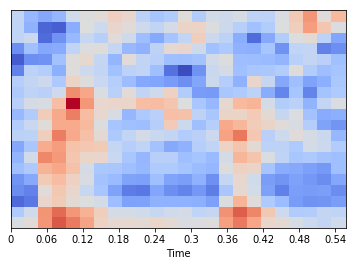

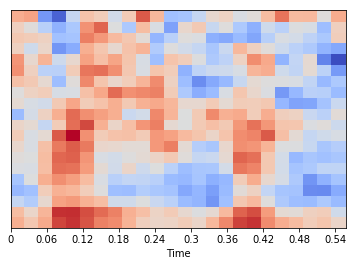

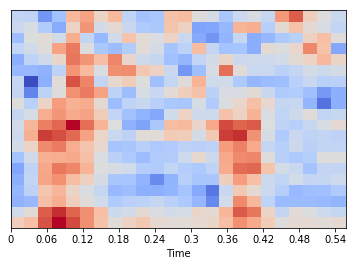

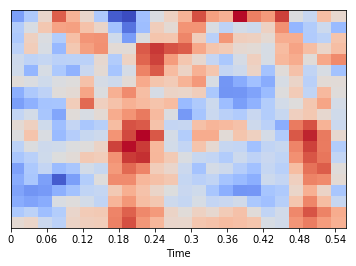

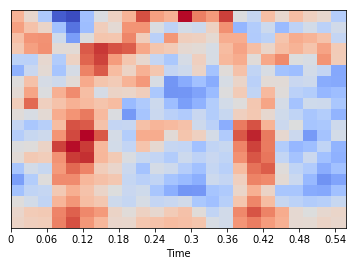

In [287]:
pred_nn = global_pred_nn>7.6
#librosa.display.specshow(test._mfcc(x[st:en]), x_axis='time')
for st in data_1[(pred_nn != (target_1==1))]:
    librosa.display.specshow(st, x_axis='time')
    plt.show()

Сверточная нн

In [9]:
test, train, target_test, target_train = train_test_split(data_2.reshape([-1,20,24,1]), target_2, train_size=0.2,shuffle =True)
test, train, target_test, target_train = train_test_split(full_data, (full_target==1), train_size=0.8,shuffle =True, random_state = 7)
input_shape = (20, 24, 1)
output_shape = 1

model_cnn = Sequential()
model_cnn.add(keras.layers.Reshape(input_shape))
model_cnn.add(Conv2D(16, kernel_size=(20, 6),
                 activation='relu',
                 input_shape=input_shape))
#model_cnn.add(AveragePooling2D((2, 2)))
#model_cnn.add(Conv2D(8, kernel_size=(2, 3),
#                 activation='relu',
#                 input_shape=input_shape))

model_cnn.add(Flatten())
# Полносвязные слои
model_cnn.add(Dense(units=120, activation='relu'))
model_cnn.add(layers.Dropout(0.1))
model_cnn.add(Dense(units=60, activation='relu'))
model_cnn.add(layers.Dropout(0.1))
#model.add(LSTM(128,activation = 'relu'))
model_cnn.add(Dense(units=output_shape, activation = 'softplus'))

model_cnn.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=['mean_squared_error'])
    #optimizer=tf.keras.optimizers.Adam(), 
             # loss =tf.keras.losses.BinaryCrossentropy(), 
             # metrics='acc')
#model_cnn.fit(train, target_train, epochs=3)

best_score = 0
for i in range(20):
    history = model_cnn.fit(train, target_train, epochs= 1, batch_size = 40)
    predict_cnn = (model_cnn.predict(test).flatten()>0.5)
    print(f1_score(predict_cnn,target_test), accuracy_score(predict_cnn,target_test))
    if best_score < f1_score(predict_cnn,target_test):
        print('!!!')
        weights_cnn = model_cnn.get_weights()
        best_model_cnn = tf.keras.models.clone_model(model_cnn)
        best_score = f1_score(predict_cnn,target_test)
model_cnn.summary()
predict_cnn = model_cnn.predict(test)>0.5
f1_score(predict_cnn,target_test), accuracy_score(predict_cnn,target_test)

59/59 [==============================] - ETA: 0s - loss: 1.2657 - mean_squared_error: 0.47 - ETA: 0s - loss: 0.6805 - mean_squared_error: 0.23 - ETA: 0s - loss: 0.5445 - mean_squared_error: 0.18 - ETA: 0s - loss: 0.4843 - mean_squared_error: 0.15 - ETA: 0s - loss: 0.4413 - mean_squared_error: 0.14 - ETA: 0s - loss: 0.4066 - mean_squared_error: 0.13 - ETA: 0s - loss: 0.3874 - mean_squared_error: 0.12 - ETA: 0s - loss: 0.3681 - mean_squared_error: 0.11 - 0s 6ms/step - loss: 0.3612 - mean_squared_error: 0.1143
0.776140350877193 0.9322429906542056
!!!
59/59 [==============================] - ETA: 0s - loss: 0.0949 - mean_squared_error: 0.02 - ETA: 0s - loss: 0.1920 - mean_squared_error: 0.04 - ETA: 0s - loss: 0.1995 - mean_squared_error: 0.05 - ETA: 0s - loss: 0.1942 - mean_squared_error: 0.06 - ETA: 0s - loss: 0.1706 - mean_squared_error: 0.05 - ETA: 0s - loss: 0.1520 - mean_squared_error: 0.05 - 0s 5ms/step - loss: 0.1501 - mean_squared_error: 0.0595
0.8512616201859229 0.9524214103653356

(0.8421411524036823, 0.9508283772302464)

In [10]:
best_score

0.8588494184218798

0.0 0.0 0.8475699558173785 0.98


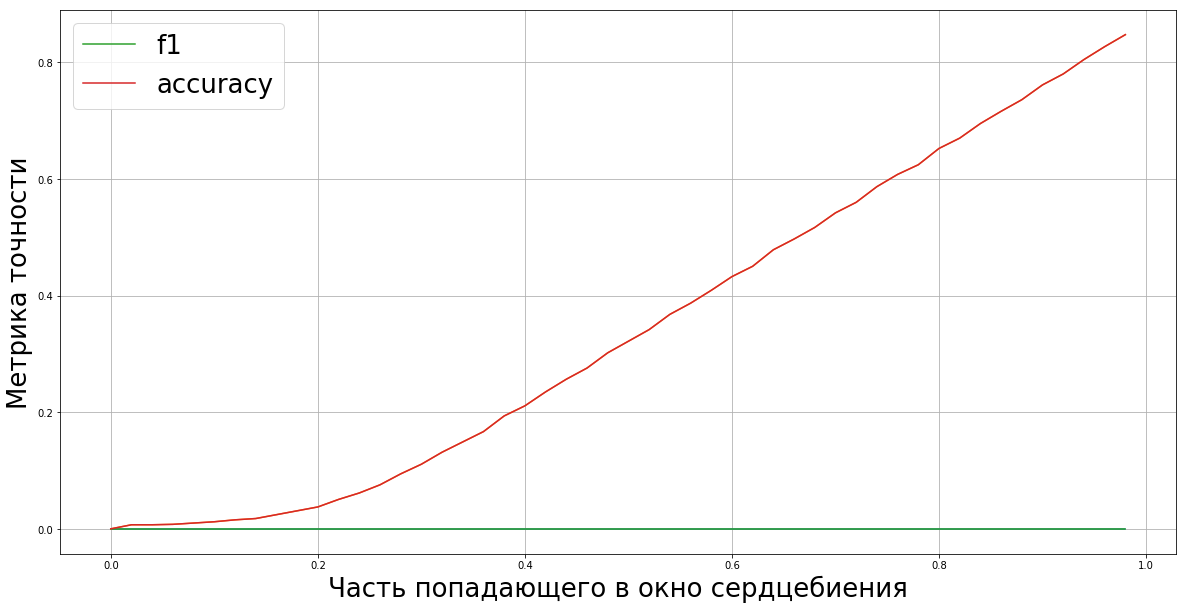

In [268]:
global_pred_cnn = model_cnn.predict(data_1.reshape([-1,20,24,1])).flatten()
koefs = np.arange(0,1, step=0.02)
f1 = np.zeros(koefs.shape[0])
acc = np.zeros(koefs.shape[0])
for i,koef in enumerate(koefs):
    f1[i], acc[i] = f1_score(global_pred_cnn>1.6,(target_1>=koef)), accuracy_score(global_pred_cnn>1.6,(target_1>=koef))
print(f1.max(), koefs[f1.argmax()],acc.max(), koefs[acc.argmax()])
plt.figure(figsize=[20,10])
plt.plot(koefs,f1)
plt.plot(koefs, acc)
plt.plot(koefs,f1, label="f1")
plt.plot(koefs, acc, label="accuracy")
plt.ylabel('Метрика точности', fontsize=26)
plt.xlabel('Часть попадающего в окно сердцебиения', fontsize=26)
plt.title('',fontsize=26)
plt.grid()
plt.legend(fontsize=26)
plt.show()

0.39933993399339934 0.0 0.8729749631811488 0.5


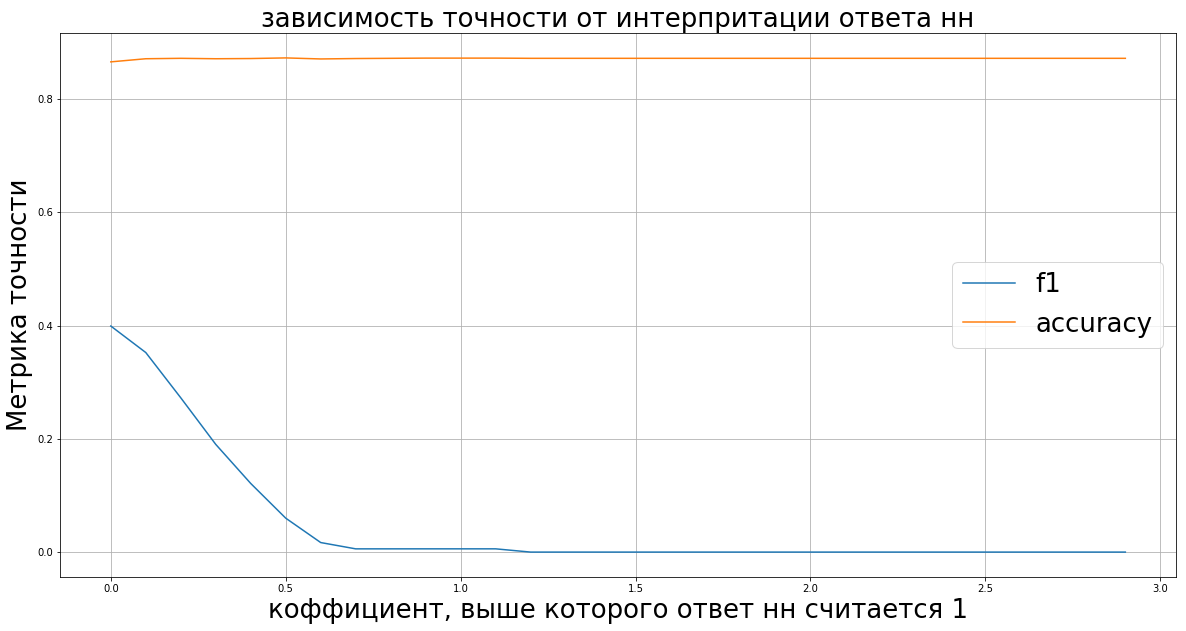

In [270]:
global_pred_cnn = model_cnn.predict(data_1.reshape([-1,20,24,1])).flatten()
koefs = np.arange(0,3, step=0.1)
f1 = np.zeros(koefs.shape[0])
acc = np.zeros(koefs.shape[0])
for i,koef in enumerate(koefs):
    f1[i], acc[i] = f1_score(global_pred_cnn>koef,(target_1==1)), accuracy_score(global_pred_cnn>koef,(target_1==1))
print(f1.max(), koefs[f1.argmax()],acc.max(), koefs[acc.argmax()])
plt.figure(figsize=[20,10])
plt.plot(koefs,f1, label="f1")
plt.plot(koefs, acc, label="accuracy")
plt.ylabel('Метрика точности', fontsize=26)
plt.xlabel('коффициент, выше которого ответ нн считается 1', fontsize=26)
plt.title('зависимость точности от интерпритации ответа нн',fontsize=26)
plt.grid()
plt.legend(fontsize=26)
plt.show()

Поиск выборки

In [70]:
model_per_1 = Sequential()

#model.add(layers.SimpleRNN(128, activation = 'relu'))
model_per_1.add(Dense(units=480, activation='relu'))
#model.add(layers.Dropout(0.1))
#model.add(LSTM(128,activation = 'relu'))
model_per_1.add(Dense(units=output_shape, activation = 'relu'))

model_per_1.compile(optimizer=keras.optimizers.Adam(), 
              loss =tf.keras.losses.BinaryCrossentropy(), 
              #metrics=['acc','mse'])
                 )

In [32]:
data_1, test_mark_1 = data_prep('clear')
true_data_2 = data_1[test_mark_1==1][4::8][:40]
true_target = np.ones(true_data_2.shape[0])
false_data_2 = data_1[test_mark_1<0.2][:40]
false_target = np.zeros(false_data_2.shape[0])
data_2 = np.concatenate((true_data_2, false_data_2), axis=0)
target_2 =  np.concatenate((true_target, false_target), axis=0)

In [79]:
%%time
name = names[0]
data_p, target_p = data_prep(name)
print(data_p.shape, target_p.shape)
target_p = target_p==1
data_flat = data_p.reshape([-1,480])
final_data = np.empty([0,480])#data_2.reshape([-1,480])
final_target = np.empty([0])#target_2
temp_f1 = 0
for i,d in enumerate(data_flat[:200]):
    #print(test_mark_1[i], final_target.shape)
    temp_data = np.concatenate((final_data, d.reshape([1,-1])), axis=0)
    temp_target = np.append(final_target, test_mark_1[i])
    
    new_model= Sequential()

    #model.add(layers.SimpleRNN(128, activation = 'relu'))
    new_model.add(Dense(units=480, activation='relu'))
    #model.add(layers.Dropout(0.1))
    #model.add(LSTM(128,activation = 'relu'))
    new_model.add(Dense(units=output_shape, activation = 'relu'))
    
    new_model.compile(optimizer=keras.optimizers.Adam(), 
              loss =tf.keras.losses.BinaryCrossentropy(), 
              #metrics=['acc','mse'])
                 )
    new_model.fit(temp_data, temp_target, epochs= 3)
    #print(temp_f1)
    
    global_pred_nn = new_model.predict(data_flat)
    koefs = np.arange(0,200, step=1)
    f1 = np.zeros(koefs.shape[0])
    acc = np.zeros(koefs.shape[0])

    for i,koef in enumerate(koefs):
        f1[i], acc[i] = f1_score(global_pred_nn>koef,(target_p==1)), accuracy_score(global_pred_nn>koef,(target_p==1))
    print(f1.max(), koefs[f1.argmax()],acc.max(), koefs[acc.argmax()])
    
    if f1.max()>temp_f1:
        temp_f1 = f1.max()
        final_data = np.concatenate((final_data, d.reshape([1,-1])), axis=0)
        final_target = np.append(final_target, test_mark_1[i])
   

(2716, 20, 24) (2716,)
Epoch 1/3
1/1 [==============================] - 4s 4s/step - loss: 13.6482
Epoch 2/3
1/1 [==============================] - 0s 32ms/step - loss: 13.6482
Epoch 3/3
1/1 [==============================] - 0s 56ms/step - loss: 13.6482
0.31438127090301005 0 0.8722385861561119 4
Epoch 1/3
2/2 [==============================] - 3s 2s/step - loss: 13.0939
Epoch 2/3
2/2 [==============================] - 0s 9ms/step - loss: 13.0939
Epoch 3/3
2/2 [==============================] - 0s 7ms/step - loss: 13.0939
0.25217391304347825 0 0.8722385861561119 2
Epoch 1/3
2/2 [==============================] - 4s 2s/step - loss: 8.3184
Epoch 2/3
2/2 [==============================] - 0s 7ms/step - loss: 2.6022
Epoch 3/3
2/2 [==============================] - 0s 4ms/step - loss: 1.8783
0.03271375464684015 0 0.8722385861561119 8
Epoch 1/3
2/2 [==============================] - 3s 2s/step - loss: 5.8230
Epoch 2/3
2/2 [==============================] - 0s 8ms/step - loss: 5.8230
Epoch 3/

In [56]:
temp_f1, final_data.shape

(0.6190476190476192, (85, 480))

Epoch 1/5
85/85 [==============================] - ETA: 0s - loss: 0.090 - 0s 824us/step - loss: 0.0949
Epoch 2/5
85/85 [==============================] - ETA: 0s - loss: 0.125 - ETA: 0s - loss: 0.080 - 0s 2ms/step - loss: 0.0949
Epoch 3/5
85/85 [==============================] - ETA: 0s - loss: 0.007 - 0s 800us/step - loss: 0.0949
Epoch 4/5
85/85 [==============================] - ETA: 0s - loss: 0.126 - 0s 729us/step - loss: 0.0949
Epoch 5/5
85/85 [==============================] - ETA: 0s - loss: 0.126 - 0s 835us/step - loss: 0.0949
0.6312684365781711 115 0.9112665684830633 129


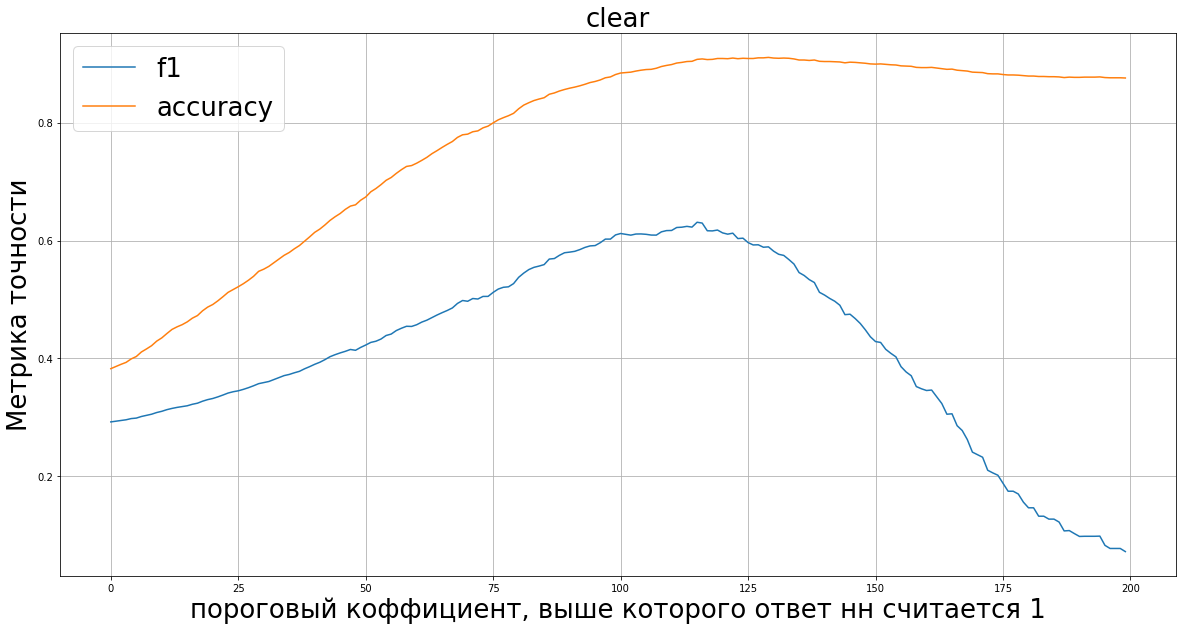

In [65]:

model_per_1.fit(final_data, final_target,epochs = 5)
global_pred_nn = model_per_1.predict(data_flat)
koefs = np.arange(0,200, step=1)
f1 = np.zeros(koefs.shape[0])
acc = np.zeros(koefs.shape[0])

for i,koef in enumerate(koefs):
        f1[i], acc[i] = f1_score(global_pred_nn>koef,(target_p==1)), accuracy_score(global_pred_nn>koef,(target_p==1))
print(f1.max(), koefs[f1.argmax()],acc.max(), koefs[acc.argmax()])
plt.figure(figsize=[20,10])
plt.plot(koefs,f1, label="f1")
plt.plot(koefs, acc, label="accuracy")
plt.ylabel('Метрика точности', fontsize=26)
plt.xlabel('пороговый коффициент, выше которого ответ нн считается 1', fontsize=26)
plt.title(name,fontsize=26)
plt.grid()
plt.legend(fontsize=26)
plt.show()